# Inferring Grammars from Binary Programs using String Inclusion

* Evaluation starts [here](#Evaluation)
  * The evaluation on specific subjects starts [here](#Subjects)
    * [Calculator](#Calculator)
    * [CSV](#CSV)
    * [URLParse](#URLParse)
    * [JSON](#JSON)
    * [TinyExpr](#TinyExpr)
    * [INI](#INI)
* Results are [here](#Results)

## Install Prerequisites

Our code is based on the utilities provided by the [Fuzzingbook](http://fuzzingbook.org). We can simply install FuzzingBook using the command below.

In [411]:
!pip install fuzzingbook==0.8.1

In [ ]:
!pip install nbconvert

### GDB Installation

**NOTE**: Please verify GDB installation on your environment before running this notebook. For details on GDB installtion, see the link below;

* For **MacOS** installation [see](https://dev.to/jasonelwood/setup-gdb-on-macos-in-2020-489k)
* For **Linux** installation [see](http://www.gdbtutorial.com/tutorial/how-install-gdb)

In [412]:
import fuzzingbook.fuzzingbook_utils

## X86 Instruction

An X86 instruction is typically made up of a line address, an instruction type which represents what type of action the instruction is meant to carry out and also a register where the action is operation on.

Below is an example of an instruction that moves a value from one register to another;

    `0x555555554892:      mov    %rsp,%rbp` 
where `0x555555554892` is the current line address, `mov` is the type of instruction that should be carried out and lastly `%rsp`,`%rbp` which represents the registers where the `mov` operation should be carried out. In this case, `mov` the content in register `rsp` to `rbp`.

### Instruction Type

We represent function call and return in an instruction set as variables. for example, an instruction type can be `call` which represent a function call.

In [413]:
CALL = 'callq'
RETURN = 'retq'

### Registers

We represent X86 registers as an array of string values

In [414]:
REGISTERS = ['rdi', 'rdx', 'rcx', 'r8', 'r9', 'rbx', 'rax', 'rsp', 'rbp', 'al']

**NOTE**: Since we are working with `GDB` we cannot run our implement directly within jupyter notebook. Therefore, we save all code implementation and variables into a single script that can be executed from command line.

In [415]:
VARIABLES = '''
CALL = 'callq'
RETURN = 'retq'

REGISTERS = ['rdi', 'rdx', 'rcx', 'r8', 'r9', 'rbx', 'rax', 'rsp', 'rbp', 'al']
'''

### Instruction

With the information that can be obtained from instructions set, we represents this as a class `Instruction`.

In [416]:
class Instruction:
    def __init__(self, instr):
        self.symbol_name = None
        self.pointed_address = None
        self.dest_reg = None
        self.instr_type = None
        self._parse(instr)

Firstly within the constructor of the `Instruction` class, the variable `symbol_name` is used to hold the name of a function, variable `pointed_address` is used to hold the address of a function that is about to be called, variable `dest_reg` is used to hold the name of the register where an operation has been carried out.

method `get_pointed_address()` is used to get the address of a function that is about to be called. This method is useful when we have a `call` instruction

In [417]:
class Instruction(Instruction):
    def get_pointed_address(self, inp_value):
        inp_value = inp_value.strip('%*')
        if inp_value in REGISTERS:
            pointed_address = gdb.execute('x/s $%s' % (inp_value),to_string=True)
            pointed_address = pointed_address.split(':')
            return pointed_address[0]
        return inp_value

 method `resolve_addressing_mode()` used to derive an expression that calculates an address in memory to be read/written to. For example, if we have the instruction `movl $1, -24(%rbp)`, we can resolve the address where the value of such instruction is located by computing `address = base $rbp + displacement -24)`

In [418]:
class Instruction(Instruction):
    def resolve_addressing_mode(self, instruction):
        splited_instruction = instruction.split(',')
        if len(splited_instruction) > 2:
            if instruction.startswith('%'):
                return '$%s' % (splited_instruction[0][1:])
            else:
                if instruction.startswith('-') or instruction.startswith('0x'):
                    displacement, base = tuple(
                        splited_instruction[0].split('(%'))
                    index = splited_instruction[1][1:]
                    scale = splited_instruction[2].strip(')')
                    return '$%s+%s+%s*$%s' % (base, displacement, scale, index)

        src = splited_instruction[-1]
        if '(' not in src:
            if src[1:] in REGISTERS:
                return '$%s' % src[1:]
        else:
            if src.startswith('-'):
                displacement, rest = tuple(src.split('(%'))
                return '$%s%s' % (rest[:-1], displacement)
            elif src.startswith('(') and src.endswith(')'):
                return '$%s' % src[2:-1]
            else:
                displacement, rest = tuple(src.split('(%'))
                return '$%s+%s' % (rest[:-1], displacement)

method `_parse()` makes use of all the functions and variables defined so far. It basically splits an instruction string into parts and assign useful part of the splited instruction into the variables defined in the constructor. Also, it resolves addressing for data movement instructions. 

Data movement instructions are instructions which basically equivalent to variable assignment. Such instruction types includes `mov`, `push`, `pop`.

In [419]:
class Instruction(Instruction):
    def _parse(self, instr):
        instr_list = instr.split()
        instr_list.pop(0)

        self.current_address = instr_list[0]
        if "<" in instr_list[1]:
            instr_list.pop(1)
        self.instr_type = instr_list[1]

        if self.instr_type == CALL:
            self.pointed_address = self.get_pointed_address(instr_list[2])
            if len(instr_list) > 3:
                self.symbol_name = instr_list[-1]

        elif self.instr_type.startswith('mov') or self.instr_type == 'push' or \
            self.instr_type == 'pop' or self.instr_type == 'cmp':
            self.dest_reg = self.resolve_addressing_mode(instr_list[2])

### Accessing memory content of registers and address

After representing instructions as an object and defining how to resolve addressing, we need read the memory content of registers or addresses pointed by the register.

Gdb provides command for reading the content of registers or an address. General format for the command is `x/nfu addr`. `x` to examine memory in any of several formats. `n`, `f`, and `u` are all optional parameters that specify how much memory to display and how to format it.

In this work, we use the commands `x/s`, `x/a` `p/c` for reading, printing string, address and single character values respectively.

The method `read_memory()` uses the desired format passed to it to read memory content.

In [420]:
def read_memory(reg, fmt):
    try:
        output = gdb.execute('%s %s' % (fmt, reg), to_string=True)
        return extract_string(output)
    except Exception:
        return

In [421]:
def extract_string(string):
    return_str = None
    for idx, char in enumerate(string):
        if string[idx] == ':':
            return_str = string[idx + 1:]
            return_str = return_str.strip()
            break
    return return_str

In [422]:
def extract_char(addr):
    char_val = gdb.execute('p/c %s' % (addr), to_string=True)
    char_val = char_val.split()
    char_val = char_val[-1]
    return char_val[1:-1]

In [423]:
read_address_string_methods = '''
def read_memory(reg, fmt):
    try:
        output = gdb.execute('%s %s' % (fmt, reg), to_string=True)
        return extract_string(output)
    except Exception:
        return
        
def extract_string(string):
    return_str = None
    for idx, char in enumerate(string):
        if string[idx] == ':':
            return_str = string[idx + 1:]
            return_str = return_str.strip()
            break
    return return_str

def extract_char(addr):
    char_val = gdb.execute('p/c %s' % (addr), to_string=True)
    char_val = char_val.split()
    char_val = char_val[-1]
    return char_val[1:-1]
'''

#### Combining both

This method `read_register_value` makes use of the above defined methods in reading the content of an address or register during debugging.

In [424]:
def read_register_value(reg, original, instr_type):
    if not reg: return None

    if instr_type.endswith('movb'):
        hex_value = read_memory(reg, 'x/x')
        if hex_value: return extract_char(hex_value)

    if reg == '$al':
        return extract_char(reg)

    val = read_memory(reg, 'x/s')
    if not val or 'error' in val:
        return None
    elif val in original:
        return val
    else:
        if val[1:-1] in original:
            return val[1:-1]
        address = read_memory(reg, 'x/a')
        str_val = read_register_value(address, original, instr_type)
        return str_val

In [425]:
read_register_value = '''
def read_register_value(reg, original, instr_type):
    if not reg: return None

    if instr_type.endswith('movb'):
        hex_value = read_memory(reg, 'x/x')
        if hex_value: return extract_char(hex_value)

    if reg == '$al':
        return extract_char(reg)

    val = read_memory(reg, 'x/s')
    if not val or 'error' in val:
        return None
    elif val in original:
        return val
    else:
        if val[1:-1] in original:
            return val[1:-1]
        address = read_memory(reg, 'x/a')
        str_val = read_register_value(address, original, instr_type)
        return str_val
'''

In [426]:
print(read_register_value)


def read_register_value(reg, original, instr_type):
    if not reg: return None

    if instr_type.endswith('movb'):
        hex_value = read_memory(reg, 'x/x')
        if hex_value: return extract_char(hex_value)

    if reg == '$al':
        return extract_char(reg)

    val = read_memory(reg, 'x/s')
    if not val or 'error' in val:
        return None
    elif val in original:
        return val
    else:
        if val[1:-1] in original:
            return val[1:-1]
        address = read_memory(reg, 'x/a')
        str_val = read_register_value(address, original, instr_type)
        return str_val



## BinaryDebugger

The `BinaryDebugger` makes use of all the above implementation so far. It is used to obtain a trace which is then used in building a grammar. The goal here is to trace through a given binary, examine instructions and extract useful information from each instruction using our `Instruction` class defined above and finally return a trace.

In [427]:
class BinaryDebugger:
    def __init__(self, inp, binary, fn_list):
        self.inp = inp
        self.binary = binary
        self.functions = fn_list
        self._set_logger()
        self.tree = {}
        self.mid = None
        self.method_map, self.method_stack = {}, []

### Binary Debugger

Here we define with some common functionalities which a debugger needs to have to debug a program. Methods `break_at()`, `finish()`, `get_instructon()`, `nexti()`, `resume()`, `run()` and `step()` are used to set breakpoint, complete program execution, get the current instruction, step to the next instruction, resume program execution and step into a function respectively.

In [428]:
class BinaryDebugger(BinaryDebugger):
    def break_at(self, address):
        gdb.execute("break *%s" % address)

    def finish(self):
        gdb.execute('finish')

    def get_instruction(self):
        return gdb.execute('x/i $rip', to_string=True)

    def nexti(self):
        gdb.execute('nexti')

    def resume(self):
        gdb.execute('continue')

    def run(self):
        gdb.execute('run')

    def step(self):
        gdb.execute('stepi')

method `_set_logger()` function is used to configure logging.

In [429]:
class BinaryDebugger(BinaryDebugger):
    def _set_logger(self):
        gdb.execute('set logging overwrite on')
        gdb.execute('set logging redirect on')
        gdb.execute('set logging on')

method `start_program()` sets the input to the program and the target binary want to debug

In [430]:
class BinaryDebugger(BinaryDebugger):
    def start_program(self):
        gdb.execute("set args '%s'" % self.inp)
        gdb.execute("file %s" % self.binary)

method `_get_address_range()` gets the address range where the program lies. The address range is needed to guide the debugger to avoid tracing scope that are not of interest.

In [431]:
class BinaryDebugger(BinaryDebugger):
    def _get_address_range(self):
        s1 = s2 = None
        e1 = e2 = None
        mappings = gdb.execute('info proc mappings', to_string=True)
        for i, line in enumerate(mappings.splitlines()):
            if i == 4:
                s1 = line.split()[0]
            elif i == 6:
                e1 = line.split()[1]
            elif i == 7:
                s2 = line.split()[0]
            elif i == 10:
                e2 = line.split()[1]
        return (s1, e1, s2, e2)

method `_in_scope()` serves as a guide when tracing through the binary. If we are in the wrong scope the debugger exits from such scope and continues tracing.

In [432]:
def get_curr_address(instr):
    instr = instr.split()
    instr.pop(0)
    return instr[0].strip(':')

In [433]:
class BinaryDebugger(BinaryDebugger):
    def _in_scope(self, instr, addr_range):
        s1, e1, s2, e2 = addr_range

        current_addr = get_curr_address(instr)
        hex_value = int(current_addr, 16)
        return True if hex_value in range(int(s1, 16), int(
            e1, 16)) or hex_value in range(int(s2, 16), int(e2, 16)) else False

In [434]:
in_scope_helper = '''
def get_curr_address(instr):
    instr = instr.split()
    instr.pop(0)
    return instr[0].strip(':')
'''

method `_get_entry_address()` the function is used to get the entry point of a program which has no debugging symbol.

In [435]:
class BinaryDebugger(BinaryDebugger):
    def _get_entry_address(self):
        self.start_program()
        self.run()

        info_file = gdb.execute('info file', to_string=True)
        entry = None

        entry_line = [
            line for line in info_file.splitlines() if 'Entry point' in line
        ]
        entry = entry_line[0]
        entry = entry.split(':')[1]
        return entry

method `_get_main_address()` makes use of the entry point obtained from the method `_get_entry_address()` in order to get the main address which is the starting point of the program.

In [436]:
class BinaryDebugger(BinaryDebugger):
    def _get_main_address(self):
        entry = self._get_entry_address()
        self.break_at(entry)
        self.run()

        instr = []
        while True:
            next_i = self.get_instruction()
            if CALL in next_i:
                break
            instr.append(next_i)
            self.step()

        instr = instr[-1].split()
        if len(instr) == 6:
            s = instr[3]
        else:
            s = instr[4]

        register = s[-3:]
        main_addr = gdb.execute('p/x $%s' % register, to_string=True)
        main_addr = main_addr.partition("= ")
        main_addr = main_addr[-1]

        return main_addr

method `_lookup_address()` looks up the symbol name that corresponds the a given address whenever there is an instruction type `call`

In [437]:
class BinaryDebugger(BinaryDebugger):
    def _lookup_address(self, addr, symbol):
        addr = addr.rstrip("\n")
        if addr in self.functions.keys():
            return self.functions[addr]
        else:
            if symbol:
                return symbol
            return None

method `_init_methodMap_methodStack()` creates and initializes a map which is used to build our method trace during program execution.

The  format for our method trace is of the form; 
```
key   : [ mid, method_name, children_ids ]
```
When this method is invoked, method trace is set with `None` as the parent and the `main`.

Also, the variable `method_stack` keeps track of method id when there is a function call and function return.

In [438]:
class BinaryDebugger(BinaryDebugger):
    def _init_methodMap_methodStack(self, mname):
        self.method_map = {'0': [0, None, [1]], '1': [1, mname, []]}
        self.method_stack = ['0', '1']

method `_init_result()` creates a map which holds all the information derived during the tracing process.

The key `methodMap` holds the derived method trace as a value. Also, the key `comparisons` holds an array of all characters processed during program execution. Each item in the `comparisons`array is of the form;
```
    [index, character, method_id]
```
where index represents the position of a fragment within the input string, character represents the character which was processed, method id represents the method where such character was being processed.

In [439]:
class BinaryDebugger(BinaryDebugger):
    def _init_result(self, inp, arg1=None):
        self.result = {
            'inputstr': inp,
            'arg': inp,
            'original': arg1,
            'methodMap': {},
            'comparisons': []
        }

One interesting question we might ask ourself is that in the case of non unique characters in an input string, how do we know which index was consumed by what function when adding items to `Comparisons` array?

###  Resolving ambiguous fragments

Suppose we have an input string `13+(73)` which is being parsed by a program. Our goal when building `Comparisons` for such input string is that we do not want to confuse index 1 of the input string (with value 3) with the index 5 of the input string (with value 3) since they are non unique.

For example, 
    if index 1 was parsed by `method_id` = 2 and index 5 was parsed by `method_id` = 7. we want to avoid having;
```
      [1, '3', 2],
      [1, '3', 7]
```
but rather,
```
      [1, '3', 2],
      [5, '3', 7]
```

To achieve this, we used a mutation strategy as described below;

* First we identify all indexes of the non unique character in the input string.
* Mutate all the indexes of the non unique character except the index we are interested in verifying.
* Re-run `BinaryDebugger` with the mutated string.
    * If the index of interested flows in the mutated string flows through the same part as index of interest in the original input string, then we found the true index.
    * If not, we try the next index in the list of duplicate index

#### Mutating input string

The `get_duplicate_indexes()` function finds all indexes of the target in the input string

In [440]:
def get_duplicate_indexes(input_str, target):
    return [i for i, c in enumerate(input_str) if target == c]

The `get_alternative_chars()` is used to find a list possible alternatives that can be used for mutating indexes in the input string.

In [441]:
import string


def get_alternative_chars(s):
    if s.isdigit():
        return list(string.digits.replace(s, ''))
    else:
        return list(string.ascii_letters.replace(s, ''))

In [442]:
mutate_string_method = '''
def get_duplicate_indexes(input_str, target):
    return [i for i, c in enumerate(input_str) if target == c]

import string
def get_alternative_chars(s):
    if s.isdigit():
        return list(string.digits.replace(s, ''))
    else:
        return list(string.ascii_letters.replace(s, ''))
'''

The method `verify_substr_path()` is used to verify the index of a non unique character in the input string. 
For a given character,
* It gets all index of the character in the input string
* For each index in the list of duplicates, it mutate all other indexes in the list of duplicates to form a new string. 
* For each newly mutated string, we re-run the program with the mutated string until we find the right index of the given character.

mutated string are passed as input into the `check()` function which does the re-run.

In [443]:
def verify_substr_path(inputstr, val, mid, module, comparisons, instr_count):
    duplicate_idxes = get_duplicate_indexes(inputstr, val)
    alternative_chars = get_alternative_chars(val)

    for i in duplicate_idxes:
        new_str = inputstr
        for j in duplicate_idxes:
            if i != j and j > i:
                c = random.choice(alternative_chars)
                new_str = new_str[:j] + c + new_str[j + 1:]

        comparison = check(new_str, [i, val, mid], module, inputstr,
                           instr_count)
        if comparison and comparison not in comparisons:
            comparisons.append(comparison)
            return comparisons
        else:
            if comparison: return comparisons
    return comparisons

In [444]:
verify_substr_path_method = '''
def verify_substr_path(inputstr, val, mid, module, comparisons, instr_count):
    duplicate_idxes = get_duplicate_indexes(inputstr, val)
    alternative_chars = get_alternative_chars(val)

    for i in duplicate_idxes:
        new_str = inputstr
        for j in duplicate_idxes:
            if i != j and j > i:
                c = random.choice(alternative_chars)
                new_str = new_str[:j] + c + new_str[j + 1:]

        comparison = check(new_str, [i, val, mid], module, inputstr, instr_count)
        if comparison and comparison not in comparisons:
            comparisons.append(comparison)
            return comparisons
        else:
            if comparison: return comparisons
    return comparisons
'''

#### Re-running the program with mutated input

The method `check()` runs the new mutated string on the input binary and check that the character we are interested in verifying flows through the same path as what was observed in the original string. 

The argument `comparison` in the `check()` method definition represents `[index, character, method_id]` we want to verify.

In [445]:
def check(new_str, comparison, module, originalstr, instr_count):
    with open(f'inp.0.txt', 'w+') as f:
        print(new_str, file=f)

    with open(f'comparison.txt', 'w+') as f:
        print(comparison, file=f)

    subprocess.call([
        'gdb', '--batch-silent', '-ex',
        "py arg0='%s'" % new_str, '-ex',
        'py arg1="%s"' % module, '-ex',
        'py arg2="%s"' % instr_count, "-x", "check2.py"
    ])

    with open(f'inp.0.txt', 'w+') as f:
        print(originalstr, file=f)

    result = None
    try:
        with open(f'updated_comparisons', 'rb') as f:
            result = jsonpickle.decode(f.read())

        if result and result == comparison: return result
    except FileNotFoundError:
        return result

In [446]:
check_method = '''
def check(new_str, comparison, module, originalstr, instr_count):
    with open(f'inp.0.txt', 'w+') as f:
        print(new_str, file=f)

    with open(f'comparison.txt', 'w+') as f:
        print(comparison, file=f)

    subprocess.call(['gdb', '--batch-silent', '-ex', "py arg0='%s'" % new_str,
    '-ex', 'py arg1="%s"' % module, '-ex', 'py arg2="%s"' % instr_count, "-x", "check2.py"])

    with open(f'inp.0.txt', 'w+') as f:
        print(originalstr, file=f)

    result = None
    try:
        with open(f'updated_comparisons', 'rb') as f:
            result = jsonpickle.decode(f.read())

        if result and result == comparison: return result
    except FileNotFoundError:
        return result
'''

The method `add_value_to_comparisons()` is used in building comparisons for all values extracted during tracing. The method takes as argument value extracted during tracing, the `method id` the value was extracted, the original input string, and the input program.

`add_value_to_comparisons()` utilizes the mutation strategy above to resolve all fragments and their respective index.

In [447]:
def add_value_to_comparisons(val, mid, inputstr, comparisons, module,
                             instr_count):
    if val and val != inputstr and mid:
        if len(val) > 1 and inputstr.count(val) == 1:
            idx = inputstr.find(val)
            if idx != -1:
                for idx in range(idx, idx + len(val)):
                    c = [idx, inputstr[idx], mid]
                    if c not in comparisons:
                        comparisons.append(c)
        elif len(val) > 1 and inputstr.count(val) > 1:
            for c in val:
                comparisons = verify_substr_path(inputstr, c, mid, module,
                                                 comparisons, instr_count)
        else:
            count = inputstr.count(val)
            if count == 1:
                idx = inputstr.find(val)
                comparisons.append([idx, val, mid])
            else:
                comparisons = verify_substr_path(inputstr, val, mid, module,
                                                 comparisons, instr_count)
    return comparisons

In [448]:
add_value_to_comparisons_method = '''
def add_value_to_comparisons(val, mid, inputstr, comparisons, module,
                             instr_count):
    if val and val != inputstr and mid:
        if len(val) > 1 and inputstr.count(val) == 1:
            idx = inputstr.find(val)
            if idx != -1:
                for idx in range(idx, idx + len(val)):
                    c = [idx, inputstr[idx], mid]
                    if c not in comparisons:
                        comparisons.append(c)
        elif len(val) > 1 and inputstr.count(val) > 1:
            for c in val:
                comparisons = verify_substr_path(inputstr, c, mid, module,
                                                 comparisons, instr_count)
        else:
            count = inputstr.count(val)
            if count == 1:
                idx = inputstr.find(val)
                comparisons.append([idx, val, mid])
            else:
                comparisons = verify_substr_path(inputstr, val, mid, module,
                                                 comparisons, instr_count)
    return comparisons
'''

### The event loop method

method `event_loop` represents the heart of the debugger which orchestrate tracing. This method brings together all the functions we have defined so far in order to derive a trace which can be used to build our desired grammar. 

In [449]:
from fuzzingbook.GrammarMiner import CallStack

In [450]:
class BinaryDebugger(BinaryDebugger):
    def event_loop(self):
        main = self._get_main_address()
        mname = self._lookup_address(main, None)
        cs = CallStack()
        cs.enter(mname)
        _, self.mid = cs.method_id

        self._init_methodMap_methodStack(mname)
        self._init_result(self.inp, arg1)
        self.break_at(main)
        self.resume()
        addr_range = self._get_address_range()
        instr_count = 0

        while True:
            try:
                nexti = self.get_instruction()
                if self._in_scope(nexti, addr_range):
                    instr = Instruction(nexti)
                    if instr.instr_type == CALL:
                        name = self._lookup_address(instr.pointed_address,
                                                    instr.symbol_name)
                        if not name or '@plt' in name or '@GLIBC' in name:
                            self.step()
                            self.finish()
                        else:
                            self.step()
                            cs.enter(name)
                            _, self.mid = cs.method_id
                            self.method_map[self.method_stack[-1]][-1].append(
                                self.mid)
                            self.method_map[str(
                                self.mid)] = [self.mid, name, []]
                            self.method_stack.append(str(self.mid))
                    elif instr.instr_type == RETURN:
                        self.step()
                        instr_count += 1
                        cs.leave()
                        if len(self.method_stack) > 1:
                            self.method_stack.pop()
                        self.mid = cs.method_id[1]
                    else:
                        self.step()
                        instr_count += 1
                        value = read_register_value(instr.dest_reg, self.inp,
                                                    instr.instr_type)
                        if value:
                            comparisons = self.result['comparisons']
                            self.result['comparisons'] = add_value_to_comparisons(value, self.mid, \
                                self.inp, comparisons, self.result['original'], instr_count)
                else:
                    self.finish()
            except gdb.error:
                break
        self.result['method_map'] = self.method_map
        self.result['comparisons'].sort(key=lambda x: x[0])
        with open('tree', 'w+') as f:
            result = jsonpickle.encode(self.result)
            f.write(result)

### Extracting function names from binary

Since we want to work directly with stripped version of a given binary, we first need to extract all the function names which will be needed for us in building a reasonable grammar.

The below functions carries out the extraction for us.

In [451]:
def list_objfile_symbols():
    proc = subprocess.Popen(['nm', 'a.out'], stdout=subprocess.PIPE)
    output = proc.stdout.read()
    output = output.splitlines()
    return output

In [452]:
def get_names_from_symbols(objfile):
    names = []
    for name in objfile:
        name = name.split()
        name = name[-1].decode('utf-8')
        if '@@GLIBC' not in name:
            names.append(name)
        continue
    return names

In [453]:
def get_function_names(inp, binary):
    function_dict = {}
    function_names = []

    symbols = list_objfile_symbols()
    functions = get_names_from_symbols(symbols)

    gdb.execute("set args '%s'" % inp)
    gdb.execute("file %s" % binary)
    gdb.execute('set confirm off')
    gdb.execute('run')
    for function in functions:
        try:
            info_address = gdb.execute('info address %s' % function,
                            to_string=True).split(' ')
            if info_address[4].startswith('0x'):
                v = info_address[4].rstrip()
                u = v.strip('.')
                function_dict[v] = function
            else:
                u = info_address[-1].rstrip()
                u = u.strip('.')
                function_dict[u] = function
        except gdb.error:
            continue
    return function_dict

In [454]:
list_objfile_symbols_mtd = '''
def list_objfile_symbols():
    proc = subprocess.Popen(['nm', 'a.out'], stdout=subprocess.PIPE)
    output = proc.stdout.read()
    output = output.splitlines()
    return output
'''
get_names_from_symbols_mtd = '''    
def get_names_from_symbols(objfile):
    names = []
    for name in objfile:
        name = name.split()
        name = name[-1].decode('utf-8')
        if '@@GLIBC' not in name:
            names.append(name)
        continue
    return names
'''
get_function_names_mtd = '''
def get_function_names(inp, binary):
    function_dict = {}
    function_names = []

    symbols = list_objfile_symbols()
    functions = get_names_from_symbols(symbols)

    gdb.execute("set args '%s'" % inp)
    gdb.execute("file %s" % binary)
    gdb.execute('set confirm off')
    gdb.execute('run')
    for function in functions:
        try:
            info_address = gdb.execute('info address %s' % function,
                            to_string=True).split(' ')
            if info_address[4].startswith('0x'):
                v = info_address[4].rstrip()
                u = v.strip('.')
                function_dict[v] = function
            else:
                u = info_address[-1].rstrip()
                u = u.strip('.')
                function_dict[u] = function
        except gdb.error:
            continue
    return function_dict
'''

### Bringing all together

In order to run the full implementation we put the source code into a single script which would then be execute using `GDB` CLI

#### The Complete Binary Debugger Implementation

In [455]:
miner_execution_code = '''
arg_0 = None
with open(f'inp.0.txt', 'r+') as f:
    arg_0 = f.read().strip()

fnames = get_function_names(arg_0, "a.out")
subprocess.call(['strip', '-s', "a.out"])

debugger = BinaryDebugger(arg_0, 'a.out', fnames)
debugger.event_loop()
'''

In [456]:
import sys
from fuzzingbook import fuzzingbook_utils

In [457]:
head = """\
import sys
sys.path.extend([%s])
sys.path.append('.')
import matplotlib.pyplot
matplotlib.pyplot._IP_REGISTERED = True
#import fuzzingbook_utils
import fuzzingbook
from fuzzingbook.GrammarMiner import CallStack
import jsonpickle
import os, subprocess
import gdb
import re, json, random
""" % (', '.join("'%s'" % str(i) for i in sys.path if i))
Instruction_src = fuzzingbook_utils.extract_class_definition(Instruction)
BinaryDebugger_src = fuzzingbook_utils.extract_class_definition(BinaryDebugger)

miner_src = '\n'.join([
    head, VARIABLES, Instruction_src, list_objfile_symbols_mtd,
    get_names_from_symbols_mtd, get_function_names_mtd, in_scope_helper,
    BinaryDebugger_src, read_address_string_methods, read_register_value,
    mutate_string_method, verify_substr_path_method,
    add_value_to_comparisons_method, check_method, miner_execution_code
])

In [458]:
with open('BMiner.py', 'w+') as f:
    print(miner_src, file=f)

#### The Complete Verifier

We create a separate script of the complete binary debugger with a slight variation in the `BinaryDebugger` class. We use this variation in order to verify input flow of non unique character.

First of all we need to modify the `event_loop()` method in the `BinaryDebugger` class. 

The intuition behind this modification is the following;
* We are not interested in generating any trace for the mutated input.
* We only need to verify a character flow and once that is done we exit the program.

In [459]:
class BinaryDebugger(BinaryDebugger):
    def event_loop(self):
        main = self._get_main_address()
        mname = self._lookup_address(main, None)
        cs = CallStack()
        cs.enter(mname)
        _, self.mid = cs.method_id
        
        self._init_methodMap_methodStack(mname)
        self._init_result(self.inp, arg1)
        self.break_at(main)
        self.resume()
        addr_range = self._get_address_range()
        instr_count = 0
        
        while True:
            try:
                nexti = self.get_instruction()
                if self._in_scope(nexti, addr_range):
                    instr = Instruction(nexti)
                    if instr.instr_type == CALL:
                        name = self._lookup_address(instr.pointed_address, instr.symbol_name)
                        if not name or '@plt' in name or '@GLIBC' in name:
                            self.step()
                            self.finish()
                        else:
                            self.step()
                            cs.enter(name)
                            _, self.mid = cs.method_id
                            self.method_map[self.method_stack[-1]][-1].append(self.mid)
                            self.method_map[str(self.mid)] = [self.mid, name, []]
                            self.method_stack.append(str(self.mid))
                    elif instr.instr_type == RETURN:
                        self.step()
                        instr_count += 1
                        cs.leave()
                        if len(self.method_stack) > 1: 
                            self.method_stack.pop()
                        self.mid = cs.method_id[1]
                    else:
                        self.step()
                        instr_count += 1
                        value = read_register_value(instr.dest_reg, self.inp, instr.instr_type)
                        if value and len(value) == 1:
                            new_arg2 = ast.literal_eval(arg_2)
                            result = value == new_arg2[1] and self.mid == new_arg2[2] \
                                and instr_count == int(arg2)
                            if result:
                                with open('updated_comparisons', 'w+') as f:
                                    obj = jsonpickle.encode([new_arg2[0], value, self.mid])
                                    f.write(obj)
                                self.finish()
                                break
                            else:
                                with open('updated_comparisons', 'w+') as f:
                                    obj = jsonpickle.encode([0, 0, 0])
                                    f.write(obj)
                else:
                    self.finish()
            except gdb.error:
                break

In [460]:
get_function_names_mtd1 = '''
def list_objfile_symbols():
    proc = subprocess.Popen(['nm', 'check'], stdout=subprocess.PIPE)
    output = proc.stdout.read()
    output = output.splitlines()
    return output
'''

In [461]:
miner_execution_code1 = '''
arg_0 = None
with open(f'inp.0.txt', 'r+') as f:
    arg_0 = f.read().strip()

with open(f'comparison.txt', 'r+') as f:
    arg_2 = f.read().strip()

flag = None
if os.path.exists('flag.txt'):
    with open(f'flag.txt', 'r+') as f:
        flag = f.read().strip()
        subprocess.call(['gcc', '-g', arg1, '-o', 'check', flag])
else:
    subprocess.call(['gcc', '-g', arg1, '-o', 'check'])

fnames = get_function_names(arg_0, "check")
subprocess.call(['strip', '-s', "check"])

debugger = BinaryDebugger(arg_0, 'check', fnames)
debugger.event_loop()
'''

In [462]:
head = """\
import sys
sys.path.extend([%s])
sys.path.append('.')
import matplotlib.pyplot
matplotlib.pyplot._IP_REGISTERED = True
#import fuzzingbook_utils
import fuzzingbook
from fuzzingbook.GrammarMiner import CallStack
import jsonpickle
import os, subprocess
import gdb
import re, json, random, ast
""" % (', '.join("'%s'" % str(i) for i in sys.path if i))
Instruction_src = fuzzingbook_utils.extract_class_definition(Instruction)
BinaryDebugger_src = fuzzingbook_utils.extract_class_definition(BinaryDebugger)

check_src = '\n'.join([
    head, VARIABLES, Instruction_src, get_function_names_mtd1,
    get_names_from_symbols_mtd, get_function_names_mtd, in_scope_helper,
    BinaryDebugger_src, read_address_string_methods, read_register_value,
    mutate_string_method, verify_substr_path_method,
    add_value_to_comparisons_method, check_method, miner_execution_code1
])

In [463]:
with open('check2.py', 'w+') as f:
    print(check_src, file=f)

## Generating Traces

Here is how one can generate traces for the `csv` program.

In [464]:
inp = '1997,van,Ford,E350'
source = 'subject/csv/csv.c'

with open(f'inp.0.txt', 'w+') as f:
    print(inp, file=f)

In [465]:
arg0 = "\"py arg0='%s'\"" % inp
arg1 = '\'py arg1="%s"\'' % source

!gcc -g {source}
!gdb --batch-silent -ex {arg0} -ex {arg1} -x BMiner.py

In [466]:
import jsonpickle
csv_trace = []
with open(f'tree', 'rb') as f:
    csv_trace.append((jsonpickle.decode(f.read())))

csv_trace

[{'inputstr': '1997,van,Ford,E350',
  'arg': '1997,van,Ford,E350',
  'original': 'subject/csv/csv.c',
  'methodMap': {},
  'comparisons': [[0, '1', 8],
   [0, '1', 8],
   [0, '1', 8],
   [0, '1', 9],
   [0, '1', 9],
   [0, '1', 9],
   [0, '1', 9],
   [0, '1', 8],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 10],
   [0, '1', 11],
   [0, '1', 12],
   [0, '1', 13],
   [0, '1', 3],
   [0, '1', 14],
   [0, '1', 22],
   [0, '1', 31],
   [1, '9', 8],
   [1, '9', 10],
   [1, '9', 11],
   [1, '9', 12],
   [1, '9', 13],
   [1, '9', 3],
   [1, '9', 14],
   [1, '9', 22],
   [1, '9', 31],
   [2, '9', 8],
   [2, '9', 11],
   [2, '9', 12],
   [2, '9', 13],
   [2, '9', 3],
   [2, '9', 14],
   [2, '9', 22],
   [2, '9', 31],
   [3, '7', 8],
   [3, '7', 8],
   [3, '7', 8],
   [3, '7', 12],
   [3, '7', 12],
   [3, '7', 13],
   [3, '7', 3],
   [3, '7', 14],
   [3, '7', 22],
   [3, '7', 31

## Mining the Traces Generated

### Reconstructing the Method Tree with Attached Character Comparisons

Reconstruct the actual method trace from a trace with the following
format
```
key   : [ mid, method_name, children_ids ]
```

In [467]:
def reconstruct_method_tree(method_map):
    first_id = None
    tree_map = {}
    for key in method_map:
        m_id, m_name, m_children = method_map[key]
        children = []
        if m_id in tree_map:
            # just update the name and children
            assert not tree_map[m_id]
            tree_map[m_id]['id'] = m_id
            tree_map[m_id]['name'] = m_name
            tree_map[m_id]['indexes'] = []
            tree_map[m_id]['children'] = children
        else:
            assert first_id is None
            tree_map[m_id] = {'id': m_id, 'name': m_name, 'children': children, 'indexes': []}
            first_id = m_id

        for c in m_children:
            assert c not in tree_map
            val = {}
            tree_map[c] = val
            children.append(val)
    return first_id, tree_map

In [468]:
from fuzzingbook.GrammarFuzzer import display_tree

In [469]:
first, csv_method_tree = reconstruct_method_tree(csv_trace[0]['method_map'])

In [470]:
def extract_node(node, id):
    symbol = str(node['id'])
    children = node['children']
    annotation = str(node['name'])
    return "%s:%s" % (symbol, annotation), children, ''

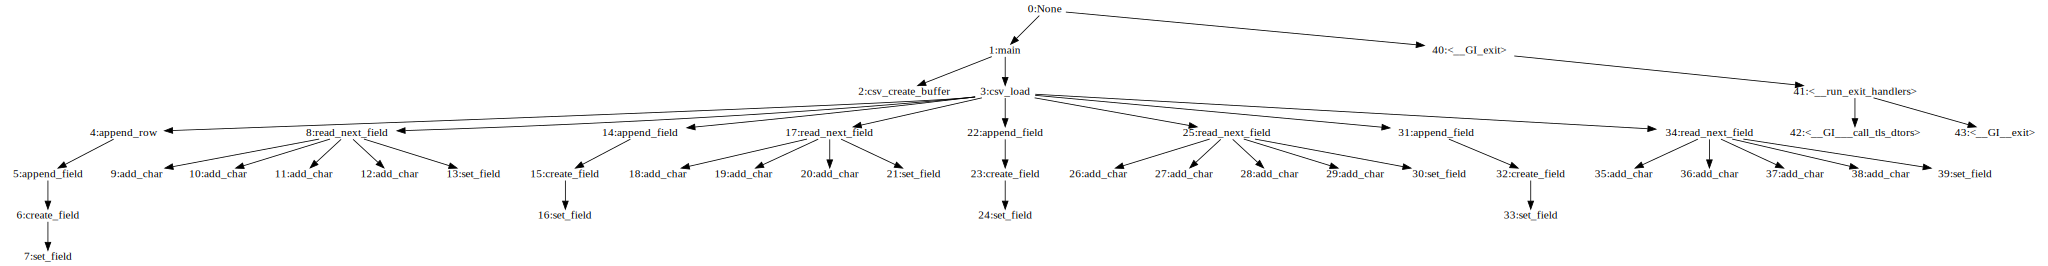

In [471]:
display_tree(csv_method_tree[0], extract_node=extract_node)

#### Identifying last comparisons
We need only the last comparisons made on any index. This means that we should care for only the last parse in an ambiguous parse. So, we assign the method that last touched an index to be its consumer.

However, to make concessions for real world, we also check if we are overwriting a child (`HEURISTIC`). Essentially, if the heursitic is enabled, then if the current method id (`midP`) is smaller than the `midC` already stored in the last comparison map, then it means that `midP` is a parent that called `midC` previously, and now accessing an index that `midC` touched. This happens when the parent tries to find a substring like `#` in the entirety of the original string. (Note that we have seen this only in `URLParser`). (Note that this heuristic does not restrict reparsing by another function call -- in such a case, `midC` will not smaller than `midP`). So, perhaps, we should let the child keep the ownership. However, there is one more wrinkle. If the character being contested was the last index touched by our `mid`, then it is likely that it was simply a boundary check. In that case, we should let the parent own this character.

In [472]:
LAST_COMPARISON_HEURISTIC = False

In [473]:
def last_comparisons(comparisons):
    last_cmp_only = {}
    last_idx = {}

    # get the last indexes compared in methods.
    for idx, char, mid in comparisons:
        if mid in last_idx:
            if idx > last_idx[mid]:
                last_idx[mid] = idx
        else:
            last_idx[mid] = idx

    for idx, char, mid in comparisons:
        if LAST_COMPARISON_HEURISTIC:
            if idx in last_cmp_only:
                midC = last_cmp_only[idx]
                if midC > mid:
                    # midC is a child of mid.
                    # do not clobber children unless it was the last character
                    # for that child.
                    if last_idx[mid] == idx:
                        # if it was the last index, may be the child used it
                        # as a boundary check.
                        pass
                    else:
                        # do not overwrite the current value of `last_cmp_only[idx]`
                        continue
        last_cmp_only[idx] = mid
    return last_cmp_only

In [474]:
csv_last_comparisons = last_comparisons(csv_trace[0]['comparisons'])

In [475]:
csv_last_comparisons

{0: 31,
 1: 31,
 2: 31,
 3: 31,
 4: 8,
 5: 21,
 6: 21,
 7: 21,
 8: 17,
 9: 30,
 10: 30,
 11: 30,
 12: 30,
 13: 25,
 14: 39,
 15: 39,
 16: 39,
 17: 39}

#### Attaching characters to the tree
Add the comparison indexes to the method tree that we constructed

In [476]:
def attach_comparisons(method_tree, comparisons):
    for idx in comparisons:
        mid = comparisons[idx]
        method_tree[mid]['indexes'].append(idx)

In [477]:
attach_comparisons(csv_method_tree, csv_last_comparisons)

In [478]:
csv_method_tree

{0: {'id': 0,
  'name': None,
  'children': [{'id': 1,
    'name': 'main',
    'indexes': [],
    'children': [{'id': 2,
      'name': 'csv_create_buffer',
      'indexes': [],
      'children': []},
     {'id': 3,
      'name': 'csv_load',
      'indexes': [],
      'children': [{'id': 4,
        'name': 'append_row',
        'indexes': [],
        'children': [{'id': 5,
          'name': 'append_field',
          'indexes': [],
          'children': [{'id': 6,
            'name': 'create_field',
            'indexes': [],
            'children': [{'id': 7,
              'name': 'set_field',
              'indexes': [],
              'children': []}]}]}]},
       {'id': 8,
        'name': 'read_next_field',
        'indexes': [4],
        'children': [{'id': 9,
          'name': 'add_char',
          'indexes': [],
          'children': []},
         {'id': 10, 'name': 'add_char', 'indexes': [], 'children': []},
         {'id': 11, 'name': 'add_char', 'indexes': [], 'children': []},
 

In [479]:
def wrap_input(istr):
    def extract_node(node, id):
        symbol = str(node['id'])
        children = node['children']
        annotation = str(node['name'])
        indexes = repr(tuple([istr[i] for i in node['indexes']]))
        return "%s %s" % (annotation, indexes), children, ''
    return extract_node

In [480]:
extract_node1 = wrap_input(csv_trace[0]['inputstr'])

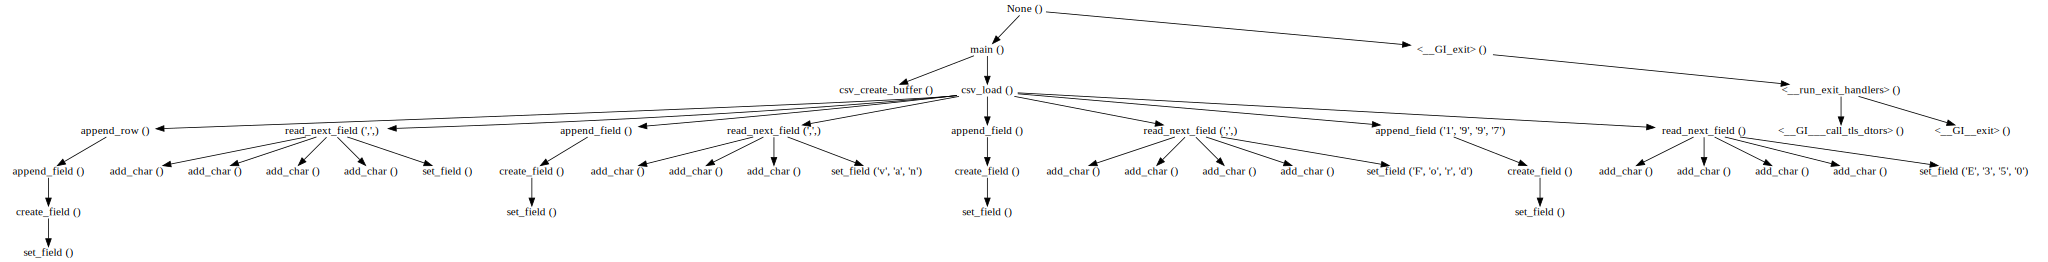

In [481]:
display_tree(csv_method_tree[0], extract_node=extract_node1)

Convert a list of indexes to a corresponding terminal tree node

In [482]:
def to_node(idxes, my_str):
    assert len(idxes) == idxes[-1] - idxes[0] + 1
    assert min(idxes) == idxes[0]
    assert max(idxes) == idxes[-1]
    return my_str[idxes[0]:idxes[-1] + 1], [], idxes[0], idxes[-1]

In [483]:
from operator import itemgetter
import itertools as it

We now need to identify the terminal (leaf) nodes. For that, we want to group contiguous letters in a node together, and call it a leaf node. So, convert our list of indexes to lists of contiguous indexes first, then convert them to terminal tree nodes. Then, return a set of one level child nodes with contiguous chars from indexes.

In [484]:
def indexes_to_children(indexes, my_str):
    lst = [
        list(map(itemgetter(1), g))
        for k, g in it.groupby(enumerate(indexes), lambda x: x[0] - x[1])
    ]

    return [to_node(n, my_str) for n in lst]

Finally, we need to remove the overlap from the trees we have so far. The idea is that, given a node, each child node of that node should be uniquely responsible for a specified range of characters, with no overlap allowed between the children. The starting of the first child to ending of the last child will be the range of the node.

#### Removing Overlap
If overlap is found, the tie is biased to the later child. That is, the later child gets to keep the range, and the former child is recursively traversed to remove overlaps from its children. If a child is completely included in the overlap, the child is excised. A few convenience functions first:

In [485]:
def does_item_overlap(r, r_):
    (s, e), (s_, e_) = r, r_
    return ((s_ >= s and s_ <= e) or 
            (e_ >= s and e_ <= e) or 
            (s_ <= s and e_ >= e))

In [486]:
def is_second_item_included(r, r_):
    (s, e), (s_, e_) = r, r_
    return (s_ >= s and e_ <= e)

In [487]:
def has_overlap(ranges, r_):
    return {r for r in ranges if does_item_overlap(r, r_)}

In [488]:
def is_included(ranges, r_):
    return {r for r in ranges if is_second_item_included(r, r_)}

In [489]:
def remove_overlap_from(original_node, orange):
    node, children, start, end = original_node
    new_children = []
    if not children:
        return None
    start = -1
    end = -1
    for child in children:
        if does_item_overlap(child[2:4], orange):
            new_child = remove_overlap_from(child, orange)
            if new_child: # and new_child[1]:
                if start == -1: start = new_child[2]
                new_children.append(new_child)
                end = new_child[3]
        else:
            new_children.append(child)
            if start == -1: start = child[2]
            end = child[3]
    if not new_children:
        return None
    assert start != -1
    assert end != -1
    return (node, new_children, start, end)

Verify that there is no overlap.

In [490]:
def no_overlap(arr):
    my_ranges = {}
    for a in arr:
        _, _, s, e = a
        r = (s, e)
        included = is_included(my_ranges, r)
        if included:
            continue  # we will fill up the blanks later.
        else:
            overlaps = has_overlap(my_ranges, r) 
            if overlaps:
                # unlike include which can happen only once in a set of
                # non-overlapping ranges, overlaps can happen on multiple parts.
                # The rule is, the later child gets the say. So, we recursively
                # remove any ranges that overlap with the current one from the
                # overlapped range.
                assert len(overlaps) == 1
                oitem = list(overlaps)[0]
                v = remove_overlap_from(my_ranges[oitem], r)
                del my_ranges[oitem]
                if v:
                    my_ranges[v[2:4]] = v
                my_ranges[r] = a
            else:
                my_ranges[r] = a
    res = my_ranges.values()
    # assert no overlap, and order by starting index
    s = sorted(res, key=lambda x: x[2])
    return s

#### Generate derivation tree

Convert a mapped tree to the _fuzzingbook_ style derivation tree.

In [491]:
def to_tree(node, my_str):
    method_name = ("<%s>" % node['name']) if node['name'] is not None else '<START>'
    indexes = node['indexes']
    node_children = [to_tree(c, my_str) for c in node.get('children', [])]
    idx_children = indexes_to_children(indexes, my_str)
    children = no_overlap([c for c in node_children if c is not None] + idx_children)
    if not children:
        return None
    start_idx = children[0][2]
    end_idx = children[-1][3]
    si = start_idx
    my_children = []
    # FILL IN chars that we did not compare. This is likely due to an i + n
    # instruction.
    for c in children:
        if c[2] != si:
            sbs = my_str[si: c[2]]
            my_children.append((sbs, [], si, c[2] - 1))
        my_children.append(c)
        si = c[3] + 1

    m = (method_name, my_children, start_idx, end_idx)
    return m

In [492]:
def is_nt(v):
    return len(v) > 1 and (v[0], v[-1]) == ('<', '>')

In [493]:
def tree_to_str(tree): # Non recursive
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *rest), *to_expand = to_expand
        if is_nt(key):
            to_expand = children + to_expand
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

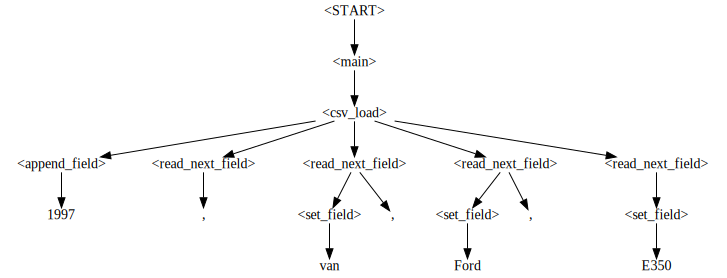

In [494]:
display_tree(to_tree(csv_method_tree[0], csv_trace[0]['inputstr']))

#### More tree examples

In [495]:
import jsonpickle

def generate_trace(inps, source, flag=None):
    traces = []
    for inp in inps:
        arg0 = "\"py arg0='%s'\"" % inp
        arg1 = '\'py arg1="%s"\'' % source
        with open(f'inp.0.txt', 'w+') as f:
            print(inp, file=f)

        if not flag:
            !gcc -g {source}
        else:
            !gcc -g {source} {flag}
        !gdb --batch-silent -ex {arg0} -ex {arg1} -x BMiner.py
    
        with open(f'tree', 'rb') as f:
            traces.append((jsonpickle.decode(f.read())))
    return traces

In [496]:
def generate_trees_from_trace(call_traces):
    my_trees = []
    for call_trace in call_traces:
        method_map = call_trace['method_map']

        first, method_tree = reconstruct_method_tree(method_map)
        comparisons = call_trace['comparisons']
        attach_comparisons(method_tree, last_comparisons(comparisons))

        my_str = call_trace['inputstr']
        tree = to_tree(method_tree[first], my_str)
        print(my_str)
        display(display_tree(tree))

In [497]:
from fuzzingbook.GrammarMiner import URLS_X, display_tree

In [498]:
inps = [
    '34+56',
    '((1))',
    '1*(5)+(7)',
    '555+(234-445)',
    '1-(41/2)', '12+34']
call_traces = generate_trace(inps, 'subject/calc/calc.c')

34+56


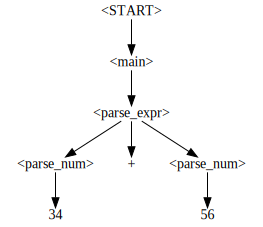

((1))


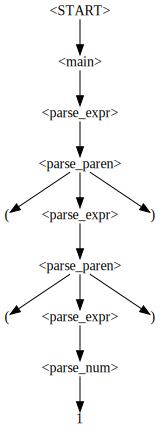

1*(5)+(7)


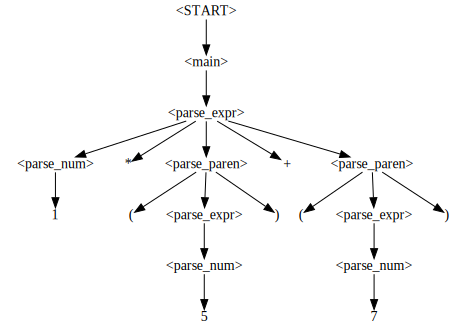

555+(234-445)


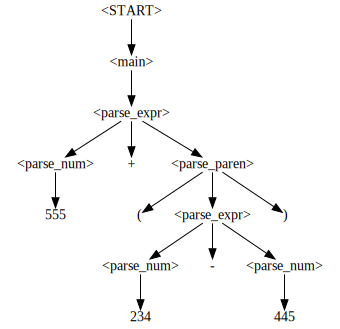

1-(41/2)


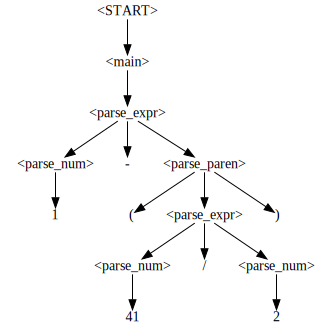

12+34


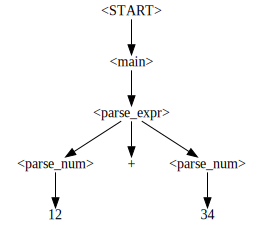

In [499]:
generate_trees_from_trace(call_traces)

In [500]:
json_samples = [
    i.strip() for i in '''\
{"color": [8, 67]}
{"c": "yellow", "b": "tryrfg"}
{"color": "yellow", "x" : {"a": "b"}}
{"array": ["8", "7", "5"], "onclick": "Createewoc", "x": {"a": "b"}}
{"value": "New", "onclick": "CreateNewDoc()"}
'''.split('\n') if i.strip()
]

In [501]:
call_traces1 = generate_trace(json_samples, 'subject/json/json.c')

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `gdb --batch-silent -ex "py arg0='{"value": "New", "onclick": "CreateNewDoc()"}'" -ex 'py arg1="subject/json/json.c"' -x BMiner.py'


{"color": [8, 67]}


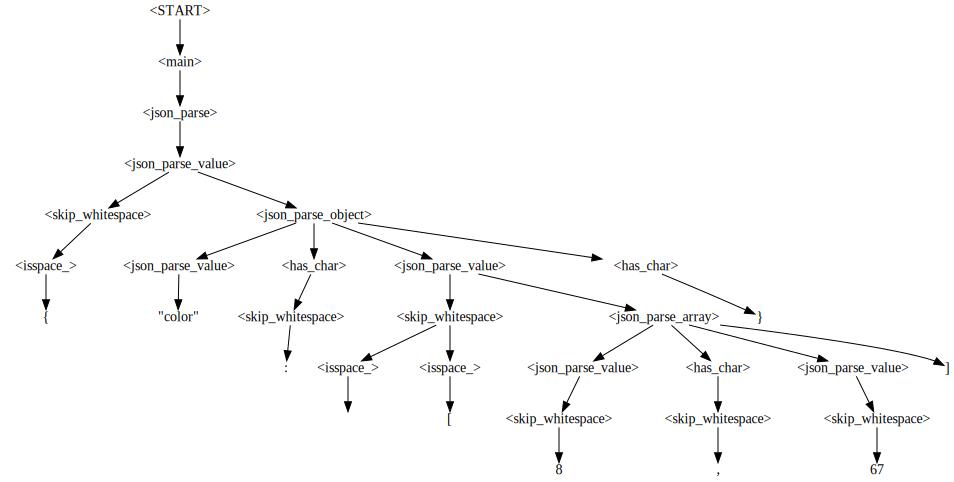

{"c": "yellow", "b": "tryrfg"}


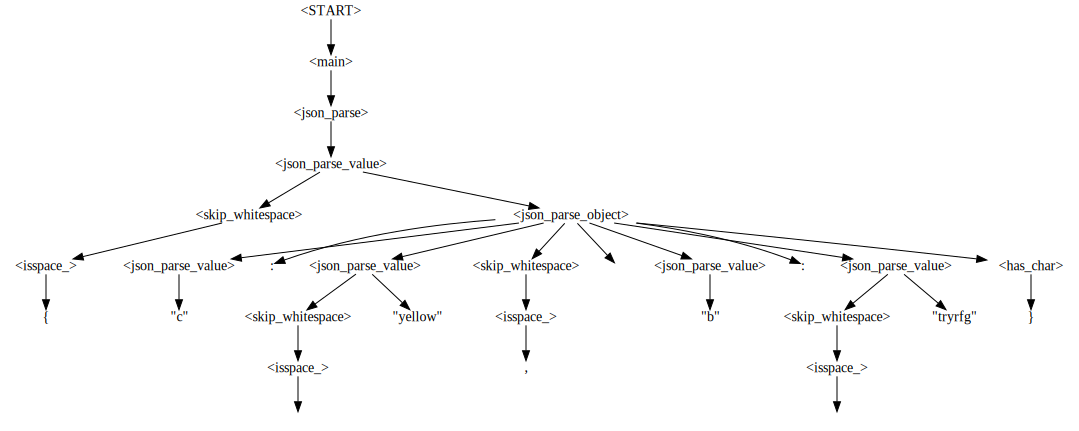

{"color": "yellow", "x" : {"a": "b"}}


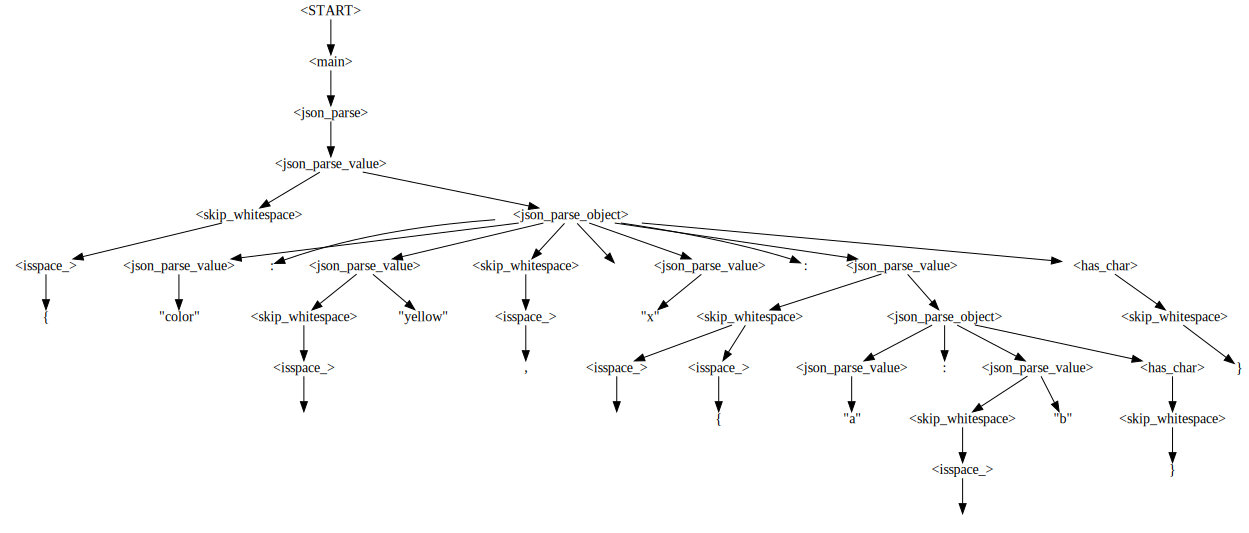

{"array": ["8", "7", "5"], "onclick": "Createewoc", "x": {"a": "b"}}


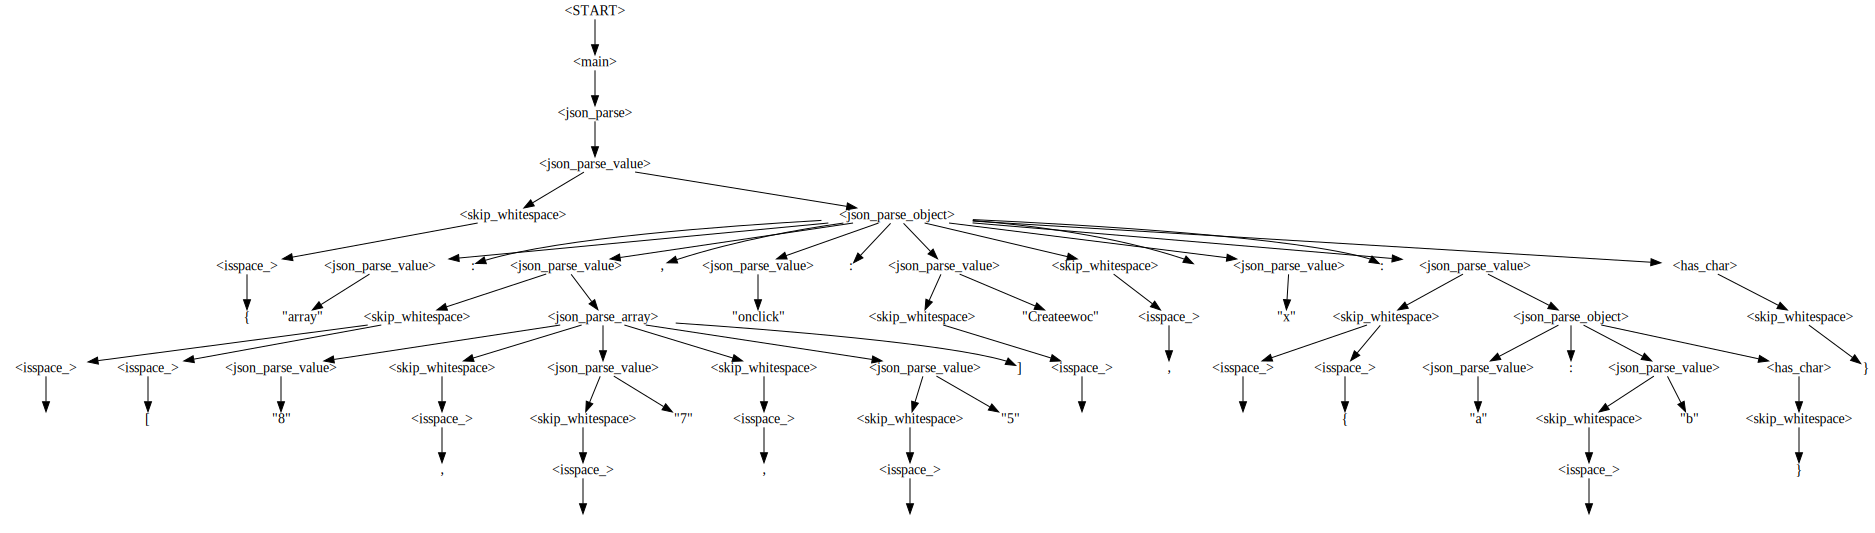

{"array": ["8", "7", "5"], "onclick": "Createewoc", "x": {"a": "b"}}


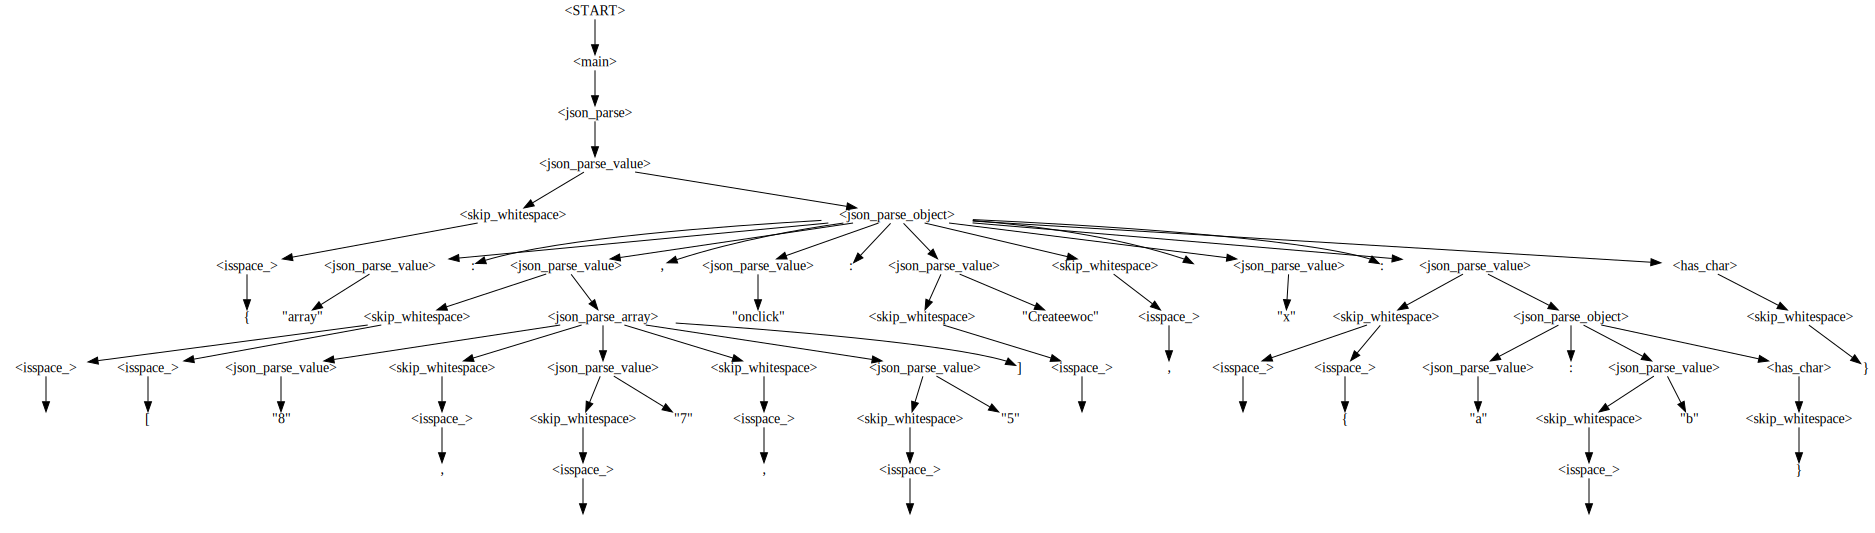

In [502]:
generate_trees_from_trace(call_traces1)

### The Complete Miner

We now put everything together. The `miner()` takes the traces, produces trees out of them, and verifies that the trees actually correspond to the input.

In [503]:
def miner(call_traces):
    my_trees = []
    for call_trace in call_traces:
        method_map = call_trace['method_map']

        first, method_tree = reconstruct_method_tree(method_map)
        comparisons = call_trace['comparisons']
        attach_comparisons(method_tree, last_comparisons(comparisons))

        my_str = call_trace['inputstr']

        tree = to_tree(method_tree[first], my_str)
        my_tree = {
            'tree': tree,
            'original': call_trace['original'],
            'arg': call_trace['arg']
        }
        assert tree_to_str(tree) == my_str
        my_trees.append(my_tree)
    return my_trees

## Generalize Method

The idea here is that, sometimes one finds that our central assumption -- that a fragment consumed by a function can be replaced by another fragment consumed by the same function elsewhere -- doesn't hold. This can be seen in functions that take an additional argument to specify what it should match. In such cases, we want to try and find out how to distinguish between these function invocations.

In [504]:
import json
NODE_REGISTER = {}
EXEC_MAP = {}

In [505]:
def reset_generalizer():
    global EXEC_MAP
    global NODE_REGISTER
    EXEC_MAP.clear()
    NODE_REGISTER.clear()

In [506]:
def to_modifiable(derivation_tree):
    node, children, *rest = derivation_tree
    return [node, [to_modifiable(c) for c in children], *rest]

In [507]:
def node_include(i, j):
    name_i, children_i, s_i, e_i = i
    name_j, children_j, s_j, e_j = j
    return is_second_item_included((s_i, e_i), (s_j, e_j))

The get_ref() takes a node datastructure and searches for node_name. It returns the first instance found. This allows us to easily swap nodes.

In [508]:
def get_ref(node, node_name):
    name, children, *rest = node
    if name == node_name:
        return node
    for child in children:
        res = get_ref(child, node_name)
        if res is not None: return res
    return None

The replace_nodes() function try to replace the contents of the first node with the contents of the second (That is, the tree that has these nodes will automatically be modified), collect the produced string from the tree, and reset any changes. The arguments are tuples with the following format: (node, file_name, tree)

In [509]:
def deep_copy(t): # Python deepcopy is a bit buggy
    v = json.dumps(t)
    return json.loads(v)

In [510]:
# replace the given node in a2 by the node in a1
def replace_nodes(a2, a1):
    node2, _, t2 = a2
    node1, _, t1 = a1
    str2_old = tree_to_str(t2)

    # first change the name of the node, then copy the tree.
    tmpl_name = '___cmimid___'
    old_name = node2[0]
    node2[0] = tmpl_name
    t2_new = deep_copy(t2)
    node2[0] = old_name

    # now find the reference to tmpl_name in t2_new
    node2 = get_ref(t2_new, tmpl_name)
    node2.clear()
    for n in node1:
        node2.append(n)
    str2_new = tree_to_str(t2_new)
    assert str2_old != str2_new
    return t2_new

Can a given node be replaced with another? The idea is, given two nodes (possibly from two trees), can the first node be replaced by the second, and still result in a valid string?

In [511]:
def is_a_replaceable_with_b(a1, a2, module):
    n1, f1, t1 = a1
    n2, f2, t2 = a2
    if tree_to_str(n1) == tree_to_str(n2): return True
    t_x = replace_nodes(a1, (('XXXX', []), None, t2))
    x = tree_to_str(t_x)
    updated_tree = replace_nodes(a1, a2)
    updated_string = tree_to_str(updated_tree)
    o = tree_to_str(t1)
    v = check(o, x, n1[0], updated_tree, module, tree_to_str(a1[0]), tree_to_str(a2[0]))
    return v

In [512]:
def is_compatible(a1, a2, module):
    t1 = is_a_replaceable_with_b(a1, a2, module)
    if not t1: return False
    t2 = is_a_replaceable_with_b(a2, a1, module)
    return t2

There are fundamentally, two kinds of nodes. The first kind of node is a method node, that correspond to a method call. The second is a node that corresponds to a pseudo-method -- that is, a node that represents a loop or a conditional. Below are the predicates that identify such methods, parses, and reconstructs such nodes.

In [513]:
def is_node_method(node):
    node_name = node[0]
    if (node_name[0], node_name[-1]) != ('<', '>'): return False
    return not is_node_pseudo(node)

In [514]:
def is_node_pseudo(node):
    node_name = node[0]
    if (node_name[0], node_name[-1]) != ('<', '>'): return False
    if ':if_' in node_name: return True
    if ':while_' in node_name: return True
    return False

In [515]:
def parse_pseudo_name(node_name):
    assert (node_name[0], node_name[-1]) == ('<','>')
    return decode_name(node_name[1:-1])

In [516]:
def parse_method_name(mname):
    assert (mname[0], mname[-1]) == ('<', '>')
    name = mname[1:-1]
    if '.' in name:
        nname, my_id = name.split('.')
        return nname, my_id
    else:
        return name, '0'

In [517]:
def decode_name(node_name_stack):
    node_name, mstack = node_name_stack.split('#')
    method_stack = json.loads(mstack)
    method_ctrl_alt_name, can_empty = node_name.split(' ')
    method, ctrl_cid_altid = method_ctrl_alt_name.split(':')
    ctrl, cid_altid = ctrl_cid_altid.split('_')
    assert ctrl in {'while', 'if'}
    cid, altid = cid_altid.split(',')

    if 'while' == ctrl:
        assert altid == '0'
    return method, ctrl, int(cid), altid, can_empty, method_stack

In [518]:
def unparse_pseudo_name(method, ctrl, ctrl_id, alt_num, can_empty, cstack):
    return "<%s>" % encode_name(method, ctrl, ctrl_id, alt_num, can_empty, cstack)

def unparse_method_name(mname, my_id):
    return '<%s.%s>' % (mname, my_id)

def encode_name(method, ctrl, ctrl_id, alt_num, can_empty, stack):
    assert ctrl in {'while', 'if'}
    return '%s:%s_%s,%s %s#%s' % (method, ctrl, ctrl_id, alt_num, can_empty, json.dumps(stack))

The check() function invokes the given subject call with the previously defined check.py wrapper, logs and returns the result of the call.

**TODO:** What we really want to do, is to generate a new updated tree first after doing the tree surgery. Then, convert this tree to a parenthesized tree by simply doing tree_to_string with additional {} (or other open/close symbols that does not conflict with the input) attached when joining the nodes. That is,

In [519]:
def tree_to_pstr(tree, op_='', _cl=''):
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *_), *to_expand = to_expand
        if is_nt(key):
            expanded.append(op_)
            to_expand = children + [(_cl, [])] + to_expand
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

With this, when using `tree_to_string(my_tree, {, })`, We will get a string that represents how the original string was parsed. For example `1+2+3` may be represented as `{{1+2}+3}`.

Next, we need to run the non-parenthesized string resulting from the tree surgery through the program, and collect the resulting tree. Again, convert this tree to the parentesized version, and compare equality.

With this, we can ensure that our tree nodes are correctly compatible, and secondly, we can ignore the return code.

In [520]:
import os, subprocess

In [521]:
def check(o, x, e, ut, module, sa1, sa2):
    s = tree_to_str(ut)
    if s in EXEC_MAP: return EXEC_MAP[s]
    updated_ps = tree_to_pstr(ut, op_='{', _cl='}')
    
    if os.path.exists('flag.txt'):
        with open(f'flag.txt', 'r+') as f:
            flag = f.read().strip()
            subprocess.call(['gcc', '-g', module, flag])
    else:
        subprocess.call(['gcc', '-g', module])
        
    v = False
    parsed_ps = None
    trace = []
    try:
        with open(f'inp.0.txt', 'w+') as f:
            print(s, file=f)
            
        arg0 = "\"py arg0='%s'\"" % s
        arg1 = '\'py arg1="%s"\'' % module
        
        !gdb --batch-silent -ex {arg1} -x BMiner.py
        with open(f'tree', 'rb') as f:
            trace.append((jsonpickle.decode(f.read())))
        
        parsed_tree = miner(trace)[0]['tree']
        parsed_ps = tree_to_pstr(parsed_tree, op_='{', _cl='}')
        v = (parsed_ps == updated_ps)
    except Exception:
        parsed_ps = 'ERROR'
        v = False

    EXEC_MAP[s] = v
    return v

We now want to collect all nodes of a particular kind together. `register_node()` correctly saves specific kinds of nodes separately as copies.

In [522]:
def register_node(node, tree, executable, input_file):
    # we want to save a copy of the tree so we can modify it later. 
    node_name = node[0]
    template_name = '__CMIMID__NODE__'
    node[0] = template_name
    new_tree = deep_copy(tree)
    node[0] = node_name
    new_node = get_ref(new_tree, template_name)
    new_node[0] = node_name
    if node_name not in NODE_REGISTER:
        NODE_REGISTER[node_name] = []
    new_elt = (new_node, new_tree, executable, input_file,
            {'inputstr': tree_to_str(new_tree), 'node':node, 'tree':tree})
    NODE_REGISTER[node_name].append(new_elt)
    return new_elt

`collect_nodes()` recursively calls `register_node()` on the tree so that all nodes are registered. The wrinkle here is that in some case such as parser combinators and peg parsers, there may be long chains of single child repetitions. i.e: parse `-> curry -> parse -> curry -> ...` etc. For them, if we have seen the first parse and curry, we do not gain anything by analyzing the remainign in the same chain. So, we mark such chains.

In [523]:
def collect_nodes_single(node, tree, executable, inputfile, seen):
    node_name, children, si, ei = node
    elt = None
    if is_node_method(node):
        elt = register_node(node, tree, executable, inputfile)
        if node_name in seen:
            elt[4]['seen'] = seen[node_name]
        else:
            seen[node_name] = elt
    if len(children) == 1:
        collect_nodes_single(children[0], tree, executable, inputfile, seen)
    else:
        # no longer the single inheritance line.
        for child in children:
            collect_nodes(child, tree, executable, inputfile)

In [524]:
def collect_nodes(node, tree, executable, inputfile):
    node_name, children, si, ei = node
    elt = None
    if is_node_method(node):
        elt = register_node(node, tree, executable, inputfile)
    if len(children) == 1:
        collect_nodes_single(children[0], tree, executable, inputfile, {node_name: elt})
    else:
        for child in children:
            collect_nodes(child, tree, executable, inputfile)

When looking to see which methods are swappable, the idea is to choose a small sample set for a given node name, and check the current node against that sample set (swap both ways, and check the validity). The different validity patterns we get are marked as different kinds of nodes.

Here, we identify the buckets based on one to one compatibility. Unfortunately, there is a problem here. Essentially, we assume that if a is compatible with b, and b is compatible with c, then a is compatible with c. However, this may not be true in all cases. See the limitations for instances when this assumption is invalidated. At this point, we have several options. The first is to do an $n \times n$ comparison of all items in the bucket, in which case, we will have the true compatibility but with high computational cost. The next alternative is to choose a node in one bucket, and do the bucketing procedure again with the items in the particular bucket. This produces one more bit of information, and one can continue this prodcedure for larger and larger number of bits. One may also choose a statistical sample of $k$ items in the bucket, and go for a comparison only between $n \times k$ items.

At this point, we choose the fastest option, which gets us a reasonable accuracy. We use a single level classification.

In [525]:
def identify_buckets(node_name):
    all_elts = NODE_REGISTER[node_name]
    # remove the duplicate nodes
    elts = [e for e in all_elts if 'seen' not in e[4]]
    seen_elts = [e for e in all_elts if 'seen' in e[4]]
    first, *rest = elts
    first[4]['pattern'] = 0
    buckets = [first]
    for enode in rest:
        node0, tree0, executable0, inputfile0, _info0 = enode
        a0 = node0, inputfile0, tree0
        compatible = None
        for bi, bnode in enumerate(buckets):
            node1, tree1, executable1, inputfile1, _info1 = bnode
            a1 = node1, inputfile1, tree1
            result = is_compatible(a0, a1, executable0)
            if result:
                compatible = bi
                enode[4]['pattern'] = bi
                break
        if compatible is None:
            enode[4]['pattern'] = len(buckets)
            buckets.append(enode)
            
    for e in seen_elts:
        e_seen = e[4]['seen']
        e_seen_pattern = e_seen[4]['pattern']
        e[4]['pattern'] = e_seen_pattern
    return {i:i for i,b in enumerate(buckets)}

Once we identify that a node belongs to a particular pattern identifier, we update all the pseudo-methods belonging to that node. These can be found by simply traversiing the tree until the next method is found.


In [526]:
def update_method_stack(node, old_name, new_name):
    nname, children, *rest = node
    if not (':if_' in nname or ':while_' in nname):
        return
    method, ctrl, cname, num, can_empty, cstack = parse_pseudo_name(nname)
    assert method == old_name, "%s != %s" % (method, old_name)
    name = unparse_pseudo_name(new_name, ctrl, cname, num, can_empty, cstack)
    #assert '?' not in name
    node[0] = name
    for c in node[1]:
        update_method_stack(c, old_name, new_name)

In [527]:
def update_method_name(k_m, my_id):
    # fixup k_m with what is in my_id
    original = k_m[0]
    method, old_id = parse_method_name(original)
    name = unparse_method_name(method, my_id)
    k_m[0] = name

    for c in k_m[1]:
        update_method_stack(c, original[1:-1], name[1:-1])

    return name, k_m

In [528]:
def update_original_method_names(node_name):
    registered_xnodes = NODE_REGISTER[node_name]
    for xnode in registered_xnodes:
        # name it according to its pattern
        nodeX, treeX, executableX, inputfileX, infoX = xnode
        pattern = infoX['pattern']
        update_method_name(infoX['node'], pattern)

The idea is to first collect and register all nodes by their names. Next, we sample N of these, and use the pattern of matches (**TODO**: Do we simply use the pattern of compatibility or the pattern of left to right replaceability -- that is, a is replaceable with b but b is not replaceable with a is 10 while full compatibility would be 11 -> 1)

In [529]:
def generalize_method_trees(jtrees, log=False):
    my_trees = []
    for i,j in enumerate(jtrees):
        tree = to_modifiable(j['tree']) # The tree ds.
        executable = j['original']
        inputfile = j['arg']
        # we skip START
        node_name, children, *rest = tree
        assert node_name == '<START>'
        for child in children:
            collect_nodes(tree, tree, executable, inputfile)
        my_trees.append({'tree':tree, 'original': executable, 'arg': inputfile})

    for k in NODE_REGISTER:
        identify_buckets(k)

    # finally, update the original names.
    for k in NODE_REGISTER:
        if k == '<START>': continue
        update_original_method_names(k)
    return my_trees

Here is how we use it.

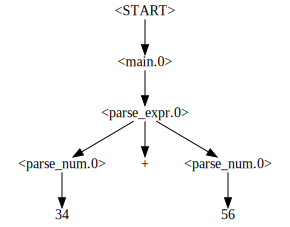

In [530]:
generalized_tree = generalize_method_trees(miner(call_traces))
display(display_tree(generalized_tree[0]['tree']))

## Generating a Grammar

Generating a grammar from the generalized derivation trees is pretty simple. Start at the start node, and any node that represents a method or a pseudo method becomes a nonterminal. The children forms alternate expansions for the nonterminal. Since all the keys are compatible, merging the grammar is simply merging the hash map.

First, we define a pretty printer for grammar.

In [531]:
import re
RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

In [532]:
def recurse_grammar(grammar, key, order, canonical):
    rules = sorted(grammar[key])
    old_len = len(order)
    for rule in rules:
        if not canonical:
            res =  re.findall(RE_NONTERMINAL, rule)
        else:
            res = rule
        for token in res:
            if token.startswith('<') and token.endswith('>'):
                if token not in order:
                    order.append(token)
    new = order[old_len:]
    for ckey in new:
        recurse_grammar(grammar, ckey, order, canonical)

In [533]:
def show_grammar(grammar, start_symbol='<START>', canonical=True):
    order = [start_symbol]
    recurse_grammar(grammar, start_symbol, order, canonical)
    if len(order) != len(grammar.keys()):
        assert len(order) < len(grammar.keys())
    return {k: sorted(grammar[k]) for k in order}

### Trees to grammar

In [534]:
def to_grammar(tree, grammar):
    node, children, _, _ = tree
    if not children: return grammar
    tokens = []
    if node not in grammar:
        grammar[node] = list()
    for c in children:
        tokens.append(c[0])
        to_grammar(c, grammar)
    grammar[node].append(tuple(tokens))
    return grammar

In [535]:
def merge_grammar(g1, g2):
    all_keys = set(list(g1.keys()) + list(g2.keys()))
    merged = {}
    for k in all_keys:
        alts = set(g1.get(k, []) + g2.get(k, []))
        merged[k] = alts
    return {k:[l for l in merged[k]] for k in merged}

In [536]:
def convert_to_grammar(my_trees):
    grammar = {}
    ret = []
    for my_tree in my_trees:
        tree = my_tree['tree']
        start = tree[0]
        src_file = my_tree['original']
        arg_file = my_tree['arg']
        ret.append((start, src_file, arg_file))
        g = to_grammar(tree, grammar)
        grammar = merge_grammar(grammar, g)
    return grammar

In [537]:
calc_grammar = convert_to_grammar(generalized_tree)
calc_grammar

{'<START>': [('<main.0>',)],
 '<parse_paren.0>': [('(', '<parse_expr.1>', ')'),
  ('(', '<parse_expr.0>', ')')],
 '<main.0>': [('<parse_expr.0>',)],
 '<parse_expr.1>': [('<parse_num.0>',)],
 '<parse_expr.0>': [('<parse_num.0>', '+', '<parse_num.0>'),
  ('<parse_paren.0>',),
  ('<parse_num.0>', '/', '<parse_num.0>'),
  ('<parse_num.0>', '*', '<parse_paren.0>', '+', '<parse_paren.0>'),
  ('<parse_num.0>', '-', '<parse_paren.0>'),
  ('<parse_num.0>', '+', '<parse_paren.0>'),
  ('<parse_num.0>', '-', '<parse_num.0>')],
 '<parse_num.0>': [('5',),
  ('41',),
  ('234',),
  ('56',),
  ('445',),
  ('2',),
  ('12',),
  ('555',),
  ('34',),
  ('1',),
  ('7',)]}

### Learning Regular Expressions

We now need to generalize the loops. The idea is to look for patterns exclusively in the similarly named while loops using any of the regular expression learners. For the prototype, we replaced the modified Sequitur with the modified Fernau which gave us better regular expressions than before. The main constraint we have is that we want to avoid repeated execution of program if possible. Fernau algorithm can recover a reasonably approximate regular exression based only on positive data.

#### The modified Fernau algorithm

The Fernau algorithm is from *Algorithms for learning regular expressions* from positive data by *HenningFernau*. Our algorithm uses a modified form of the Prefix-Tree-Acceptor from Fernau. First we define an LRF buffer of a given size.

In [538]:
class Buf:
    def __init__(self, size):
        self.size = size
        self.items = [None] * self.size

The `add1()` takes in an array, and transfers the first element of the array into the end of current buffer, and simultaneously drops the first element of the buffer.

In [539]:
class Buf(Buf):
    def add1(self, items):
        self.items.append(items.pop(0))
        return self.items.pop(0)

For equality between the buffer and an array, we only compare when both the array and the items are actually elements and not chunked arrays.

In [540]:
class Buf(Buf):
    def __eq__(self, items):
        if any(isinstance(i, dict) for i in self.items): return False
        if any(isinstance(i, dict) for i in items): return False
        return items == self.items

The `detect_chunks()` detects any repeating portions of a list of n size.

In [541]:
def detect_chunks(n, lst_):
    lst = list(lst_)
    chunks = set()
    last = Buf(n)
    # check if the next_n elements are repeated.
    for _ in range(len(lst) - n):
        lnext_n = lst[0:n]
        if last == lnext_n:
            # found a repetition.
            chunks.add(tuple(last.items))
        else:
            pass
        last.add1(lst)
    return chunks

Once we have detected plausible repeating sequences, we gather all similar sequences into arrays.

In [542]:
def chunkify(lst_,n , chunks):
    lst = list(lst_)
    chunked_lst = []
    while len(lst) >= n:
        lnext_n = lst[0:n]
        if (not any(isinstance(i, dict) for i in lnext_n)) and tuple(lnext_n) in chunks:
            chunked_lst.append({'_':lnext_n})
            lst = lst[n:]
        else:
            chunked_lst.append(lst.pop(0))
    chunked_lst.extend(lst)
    return chunked_lst

The `identify_chunks()` simply calls the `detect_chunks()` on all given lists, and then converts all chunks identified into arrays.

In [543]:
def identify_chunks(my_lsts):
    # initialize
    all_chunks = {}
    maximum = max(len(lst) for lst in my_lsts)
    for i in range(1, maximum//2+1):
        all_chunks[i] = set()

    # First, identify chunks in each list.
    for lst in my_lsts:
        for i in range(1,maximum//2+1):
            chunks = detect_chunks(i, lst)
            all_chunks[i] |= chunks

    # Then, chunkify
    new_lsts = []
    for lst in my_lsts:
        for i in range(1,maximum//2+1):
            chunks = all_chunks[i]
            lst = chunkify(lst, i, chunks)
        new_lsts.append(lst)
    return new_lsts

#### *Prefix tree acceptor*

The prefix tree acceptor is a way to represent positive data. The Node class holds a single node in the prefix tree acceptor.

In [544]:
class Node:
    # Each tree node gets its unique id.
    _uid = 0
    def __init__(self, item):
        # self.repeats = False
        self.count = 1 # how many repetitions.
        self.counters = set()
        self.last = False
        self.children = []
        self.item = item
        self.uid = Node._uid
        Node._uid += 1

    def update_counters(self):
        self.counters.add(self.count)
        self.count = 0
        for c in self.children:
            c.update_counters()

    def __repr__(self):
        return str(self.to_json())

    def __str__(self):
        return str("(%s, [%s])", (self.item, ' '.join([str(i) for i in self.children])))

    def to_json(self):
        s = ("(%s)" % ' '.join(self.item['_'])) if isinstance(self.item, dict) else str(self.item)
        return (s, tuple(self.counters), [i.to_json() for i in self.children])

    def inc_count(self):
        self.count += 1

    def add_ref(self):
        self.count = 1

    def get_child(self, c):
        for i in self.children:
            if i.item == c: return i
        return None

    def add_child(self, c):
        # first check if it is the current node. If it is, increment
        # count, and return ourselves.
        if c == self.item:
            self.inc_count()
            return self
        else:
            # check if it is one of the children. If it is a child, then
            # preserve its original count.
            nc = self.get_child(c)
            if nc is None:
                nc = Node(c)
                self.children.append(nc)
            else:
                nc.add_ref()
            return nc

The `update_tree()` essentially transforms a list of nodes to a chain of nodes starting at root if the root is an empty tree. If the root already contains a tree, the `update_tree()` traverses the path represented by `lst_` and makes a new child branch where the path specified doesn't exist in the tree.

In [545]:
def update_tree(lst_, root):
    lst = list(lst_)
    branch = root
    while lst:
        first, *lst = lst
        branch = branch.add_child(first)
    branch.last = True
    return root

Given a number of lists, the `create_tree_with_lists()` creates an actual tree out of these lists.

In [546]:
def create_tree_with_lsts(lsts):
    Node._uid = 0
    root =  Node(None)
    for lst in lsts:
        root.count = 1 # there is at least one element.
        update_tree(lst, root)
        root.update_counters()
    return root

Given a node, and a key, return the key and alts as a dict.

In [547]:
def get_star(node, key):
    if node.item is None:
        return [], {}
    if isinstance(node.item, dict):
        # take care of counters
        elements = node.item['_']
        my_key = "<%s-%d-s>" % (key, node.uid)
        alts = [elements]
        if len(node.counters) > 1: # repetition
            alts.append(elements + [my_key])
        return [my_key], {my_key:alts}
    else:
        return [str(node.item)], {}

In [548]:
def node_to_grammar(node, grammar, key):
    rule = []
    alts = [rule]
    if node.uid == 0:
        my_key = "<%s>" % key
    else:
        my_key = "<%s-%d>" % (key, node.uid)
    grammar[my_key] = alts
    if node.item is not None:
        mk, g = get_star(node, key)
        rule.extend(mk)
        grammar.update(g)
    # is the node last?
    if node.last:
        assert node.item is not None
        # add a duplicate rule that ends here.
        ending_rule = list(rule)
        # if there are no children, the current rule is
        # any way ending.
        if node.children:
            alts.append(ending_rule)

    if node.children:
        if len(node.children) > 1:
            my_ckey = "<%s-%d-c>" % (key, node.uid)
            rule.append(my_ckey)
            grammar[my_ckey] = [ ["<%s-%d>" % (key, c.uid)] for c in node.children]
        else:
            my_ckey = "<%s-%d>" % (key, node.children[0].uid)
            rule.append(my_ckey)
    else:
        pass
    for c in node.children:
        node_to_grammar(c, grammar, key)
    return grammar

def generate_grammar(lists, key):
    lsts = identify_chunks(lists)
    tree = create_tree_with_lsts(lsts)
    grammar = {}
    node_to_grammar(tree, grammar, key)
    return grammar

Given a rule, determine the abstraction for it.

In [549]:
def collapse_alts(rules, k):
    ss = [[str(r) for r in rule] for rule in rules]
    x = generate_grammar(ss, k[1:-1])
    return x

In [550]:
def collapse_rules(grammar):
    r_grammar = {}
    for k in grammar:
        new_grammar = collapse_alts(grammar[k], k)
        # merge the new_grammar with r_grammar
        # we know none of the keys exist in r_grammar because
        # new keys are k prefixed.
        for k_ in new_grammar:
            r_grammar[k_] = new_grammar[k_]
    return r_grammar

In [551]:
def convert_spaces_in_keys(grammar):
    keys = {key: key.replace(' ', '_') for key in grammar}
    new_grammar = {}
    for key in grammar:
        new_alt = []
        for rule in grammar[key]:
            new_rule = []
            for t in rule:
                for k in keys:
                    t = t.replace(k, keys[k])
                new_rule.append(t)
            new_alt.append(new_rule)
        new_grammar[keys[key]] = new_alt
    return new_grammar

In [552]:
collapsed_calc_grammar = collapse_rules(calc_grammar)
collapsed_calc_grammar

{'<START>': [['<START-1>']],
 '<START-1>': [['<main.0>']],
 '<parse_paren.0>': [['<parse_paren.0-1>']],
 '<parse_paren.0-1>': [['(', '<parse_paren.0-1-c>']],
 '<parse_paren.0-1-c>': [['<parse_paren.0-2>'], ['<parse_paren.0-4>']],
 '<parse_paren.0-2>': [['<parse_expr.1>', '<parse_paren.0-3>']],
 '<parse_paren.0-3>': [[')']],
 '<parse_paren.0-4>': [['<parse_expr.0>', '<parse_paren.0-5>']],
 '<parse_paren.0-5>': [[')']],
 '<main.0>': [['<main.0-1>']],
 '<main.0-1>': [['<parse_expr.0>']],
 '<parse_expr.1>': [['<parse_expr.1-1>']],
 '<parse_expr.1-1>': [['<parse_num.0>']],
 '<parse_expr.0>': [['<parse_expr.0-0-c>']],
 '<parse_expr.0-0-c>': [['<parse_expr.0-1>'], ['<parse_expr.0-4>']],
 '<parse_expr.0-1>': [['<parse_num.0>', '<parse_expr.0-1-c>']],
 '<parse_expr.0-1-c>': [['<parse_expr.0-2>'],
  ['<parse_expr.0-5>'],
  ['<parse_expr.0-7>'],
  ['<parse_expr.0-11>']],
 '<parse_expr.0-2>': [['+', '<parse_expr.0-2-c>']],
 '<parse_expr.0-2-c>': [['<parse_expr.0-3>'], ['<parse_expr.0-13>']],
 '<pa

### Remove duplicate and redundant entries

**IMPORTANT** we indicate things that operate on canonical by _c, and those that operate on fuzzable by _f, and both by _cf


In [553]:
def first_in_chain(token, chain):
    while True:
        if token in chain:
            token = chain[token]
            assert isinstance(token, str)
        else:
            break
    return token

Return a new symbol for grammar based on symbol_name.

In [554]:
def new_symbol(grammar, symbol_name="<symbol>"):
    if symbol_name not in grammar:
        return symbol_name

    count = 1
    while True:
        tentative_symbol_name = symbol_name[:-1] + "-" + repr(count) + ">"
        if tentative_symbol_name not in grammar:
            return tentative_symbol_name
        count += 1

Replace keys that have a single token definition with the token in the defition.

In [555]:
def replacement_candidate_chains(grammar, ignores):
    to_replace = {}
    for k in grammar:
        if k in ignores: continue
        if len(grammar[k]) != 1: continue
        rule = grammar[k][0]
        if len(rule) != 1: continue
        if is_nt(rule[0]):
            to_replace[k] = rule[0]
        else:
            pass
    return to_replace

In [556]:
def replace_key_by_new_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        new_rules = []
        for rule in grammar[key]:
            new_rule = [keys_to_replace.get(token, token)
                        for token in rule]
            new_rules.append(new_rule)
        new_grammar[keys_to_replace.get(key, key)] = new_rules
    assert len(grammar) == len(new_grammar)
    return new_grammar

In [557]:
def replace_key_by_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue
        new_rules = []
        for rule in grammar[key]:
            for t in rule:
                assert isinstance(t, str)
            new_rule = [first_in_chain(token, keys_to_replace) for token in rule]
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

In [558]:
def replace_key_by_key(grammar, keys_to_replace):
    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue
        new_rules = []
        for rule in grammar[key]:
            for t in rule:
                assert isinstance(t, str)
            new_rule = [first_in_chain(token, keys_to_replace) for token in rule]
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

In [559]:
def remove_single_entries(grammar):
    keys_to_replace = replacement_candidate_chains(grammar, {start_symbol, '<main>'})
    return replace_key_by_key(grammar, keys_to_replace)

Remove keys that have similar rules.

In [560]:
def collect_duplicate_rule_keys(grammar):
    collect = {}
    for k in grammar:
        salt = str(sorted(grammar[k]))
        if salt not in collect:
            collect[salt] = (k, set())
        else:
            collect[salt][1].add(k)
    return collect

In [561]:
def remove_duplicate_rule_keys(grammar):
    g = grammar
    while True:
        collect = collect_duplicate_rule_keys(g)
        keys_to_replace = {}
        for salt in collect:
            k, st = collect[salt]
            for s in st:
                keys_to_replace[s] = k
        if not keys_to_replace:
            break
        g = replace_key_by_key(g, keys_to_replace)
    return g

Remove all the control flow vestiges from names, and simply name them sequentially.

In [562]:
def collect_replacement_keys(grammar):
    g = deep_copy(grammar)
    to_replace = {}
    for k in grammar:
        if ':' in k:
            first, rest = k.split(':')
            sym = new_symbol(g, symbol_name=first + '>')
            assert sym not in g
            g[sym] = None
            to_replace[k] = sym
        else:
            continue
    return to_replace

Remove keys that are referred to only from a single rule, and which have a single alternative. Import. This can't work on canonical representation. First, given a key, we figure out its distance to `<START>`.

This is different from `remove_single_entries()` in that, there we do not care if the key is being used multiple times. Here, we only replace keys that are referred to only once.

In [563]:
import math

In [564]:
def len_to_start(item, parents, start_symbol, seen=None):
    if seen is None: seen = set()
    if item in seen: return math.inf
    seen.add(item)
    if item == start_symbol: return 0
    else: return 1 + min(len_to_start(p, parents, start_symbol, seen)
                         for p in parents[item])

In [565]:
def order_by_length_to_start(items, parent_map, start_symbol):
    return sorted(items, key=lambda i: len_to_start(i, parent_map, start_symbol))

Next, we generate a map of `child -> [parents]`.

In [566]:
def get_parents_of_tokens(grammar, key, seen=None, parents=None):
    if parents is None: parents, seen = {}, set()
    if key in seen: return parents
    seen.add(key)
    for res in grammar[key]:
        for token in res:
            if not is_nt(token): continue
            parents.setdefault(token, []).append(key)
    for ckey in {i for i in  grammar if i not in seen}:
        get_parents_of_tokens(grammar, ckey, seen, parents)
    return parents

In [567]:
def remove_references(keys_to_replace):
    to_process = list(keys_to_replace.keys())
    updated_dict = {}
    references = {}
    order = []
    while to_process:
        key, *to_process = to_process
        rule = keys_to_replace[key]
        new_rule = []
        skip = False
        for token in rule:
            if token not in updated_dict:
                if token in to_process:
                    # so this token will get defined later. We simply postpone
                    # the processing of this key until that key is defined.
                    # TODO: check for cycles.
                    to_process.append(key)
                    references.setdefault(token, set()).add(key)
                    skip = True
                    break
                else:
                    new_rule.append(token)
            else:
                new_rule.extend(updated_dict[token])
        if not skip:
            order.append(key)
            updated_dict[key] = new_rule
    return updated_dict

In [568]:
def replace_keys_by_rule(grammar, keys_to_replace):
    # we now need to verify that none of the keys are part of the sequences.
    keys_to_replace = remove_references(keys_to_replace)

    new_grammar = {}
    for key in grammar:
        if key in keys_to_replace: continue

        new_rules = []
        for rule in grammar[key]:
            new_rule = []
            for token in rule:
                if token in keys_to_replace:
                    new_rule.extend(keys_to_replace[token])
                else:
                    new_rule.append(token)
            new_rules.append(new_rule)
        new_grammar[key] = new_rules
    return new_grammar

Now, all together.

In [569]:
def remove_single_alts(grammar, start_symbol):
    single_alts = {p for p in grammar if len(grammar[p]) == 1 and p != start_symbol}

    child_parent_map = get_parents_of_tokens(grammar, start_symbol)
    assert len(child_parent_map) < len(grammar)

    single_refs = {p:child_parent_map[p] for p in single_alts if len(child_parent_map[p]) <= 1}

    ordered = order_by_length_to_start(single_refs, child_parent_map, start_symbol)

    for p in ordered:
        assert len(grammar[p]) == 1
        if not isinstance(grammar[p][0], str):
            print(p, grammar[p][0])

    keys_to_replace = {p:grammar[p][0] for p in ordered}
    g =  replace_keys_by_rule(grammar, keys_to_replace)
    return g

remove similar rules from under a single key

In [570]:
def len_rule(r): return len(r)
def len_definition(d): return sum([len_rule(r) for r in d])
def len_grammar(g): return sum([len_definition(g[k]) for k in g])

In [571]:
def remove_duplicate_rules_in_a_key(g):
    g_ = {}
    for k in g:
        s = {str(r):r for r in g[k]}
        g_[k] = list(sorted(list(s.values())))
    return g_

In [572]:
def grammar_gc(grammar, start_symbol):
    def strip_key(grammar, key, order):
        rules = sorted(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    assert len(order) == len(grammar.keys())
    g = {k: sorted(grammar[k]) for k in order}
    for k in g:
        for r in g[k]:
            for t in r:
                assert isinstance(t, str)
    return g

In [573]:
def cleanup_grammar(g, start_symbol):
    g = grammar_gc(g, start_symbol)
    #g1 = check_empty_rules(g) # add optional rules
    g1 = grammar_gc(g, start_symbol)
 
    g2 = collapse_rules(g1) # learn regex
    g2 = grammar_gc(g2, start_symbol)

    g3 = convert_spaces_in_keys(g2) # fuzzable grammar
    g3 = grammar_gc(g3, start_symbol)
    return g3

In [574]:
def remove_single_entry_chains(grammar, start_symbol):
    keys_to_replace = replacement_candidate_chains(grammar, {start_symbol, '<main>'})
    return replace_key_by_key(grammar, keys_to_replace)

In [575]:
def cleanup_token_names(grammar):
    keys_to_replace = collect_replacement_keys(grammar)
    g = replace_key_by_new_key(grammar, keys_to_replace)
    return g

In [576]:
def remove_self_definitions(g):
    g_ = {}
    for k in g:
        rs_ = []
        for r in g[k]:
            assert not isinstance(r, str)
            if len(r) == 1 and r[0] == k: continue
            rs_.append(r)
        g_[k] = rs_
    return g_

In [577]:
def compact_grammar(e, start_symbol):
    assert start_symbol in e
    l = len_grammar(e)
    diff = 1
    while diff > 0:
        assert start_symbol in e
        e = remove_single_entry_chains(e, start_symbol)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_duplicate_rule_keys(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = cleanup_token_names(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_single_alts(e, start_symbol)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_duplicate_rules_in_a_key(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        e = remove_self_definitions(e)
        e = grammar_gc(e, start_symbol) # garbage collect

        l_ = len_grammar(e)
        diff = l - l_
        l = l_
    e = grammar_gc(e, start_symbol)
    return e


In [578]:
compact_grammar(collapsed_calc_grammar, start_symbol='<START>')

<parse_expr.0-1> ['<parse_num.0-0-c>', '<parse_expr.0-1-c>']
<parse_expr.0-7> ['*', '<parse_expr.0-8>']
<parse_expr.0-5> ['/', '<parse_num.0-0-c>']
<parse_expr.0-11> ['-', '<parse_expr.0-11-c>']
<parse_expr.0-2> ['+', '<parse_expr.0-11-c>']
<parse_expr.0-8> ['<parse_paren.0-1>', '<parse_expr.0-9>']
<parse_expr.0-9> ['+', '<parse_paren.0-1>']
<parse_paren.0-2> ['<parse_num.0-0-c>', '<parse_paren.0-3>']
<parse_paren.0-4> ['<parse_expr.0-0-c>', '<parse_paren.0-3>']
<parse_num.0-9> ['34']
<parse_num.0-4> ['56']
<parse_num.0-11> ['7']
<parse_num.0-7> ['12']
<parse_num.0-5> ['445']
<parse_num.0-8> ['555']
<parse_num.0-1> ['5']
<parse_num.0-2> ['41']
<parse_num.0-6> ['2']
<parse_num.0-3> ['234']
<parse_num.0-10> ['1']


{'<START>': [['<parse_expr.0-0-c>']],
 '<parse_expr.0-0-c>': [['<parse_num.0-0-c>', '<parse_expr.0-1-c>'],
  ['<parse_paren.0-1>']],
 '<parse_num.0-0-c>': [['1'],
  ['12'],
  ['2'],
  ['234'],
  ['34'],
  ['41'],
  ['445'],
  ['5'],
  ['555'],
  ['56'],
  ['7']],
 '<parse_expr.0-1-c>': [['*', '<parse_paren.0-1>', '+', '<parse_paren.0-1>'],
  ['+', '<parse_expr.0-11-c>'],
  ['-', '<parse_expr.0-11-c>'],
  ['/', '<parse_num.0-0-c>']],
 '<parse_paren.0-1>': [['(', '<parse_paren.0-1-c>']],
 '<parse_expr.0-11-c>': [['<parse_num.0-0-c>'], ['<parse_paren.0-1>']],
 '<parse_paren.0-1-c>': [['<parse_expr.0-0-c>', '<parse_paren.0-3>'],
  ['<parse_num.0-0-c>', '<parse_paren.0-3>']],
 '<parse_paren.0-3>': [[')']]}

## Output Grammar

In [579]:
import jsonpickle
from fuzzingbook.Parser import non_canonical, canonical

In [580]:
def binary_miner(seeds, executable, flag=None):
    call_trace = []
    for inp in seeds:
        arg0 = "\"py arg0='%s'\"" % inp
        arg1 = '\'py arg1="%s"\'' % executable
        
        with open(f'inp.0.txt', 'w+') as f:
            print(inp, file=f)
        
        if flag:
            !gcc -g {executable} {flag}
            with open(f'flag.txt', 'w+') as f:
                print(flag, file=f)
        else:
            !gcc -g {executable}       
        
        !gdb --batch-silent -ex {arg1} -x BMiner.py
        with open(f'tree', 'rb') as f:
            call_trace.append((jsonpickle.decode(f.read())))
            
    mined_tree = miner(call_trace)   
    reset_generalizer()
    generalized_m_tree = generalize_method_trees(mined_tree)
    reset_generalizer()
    
    g0 = convert_to_grammar(generalized_m_tree)
    g = cleanup_grammar(g0, start_symbol='<START>')
    g = compact_grammar(g, start_symbol='<START>')
    return show_grammar(non_canonical(g), canonical=False)

In [581]:
binary_miner(['1*2-7', '4/6'], 'subject/calc/calc.c')

<parse_expr.0-1> ['<parse_num.0-0-c>', '<parse_expr.0-1-c>']
<parse_expr.0-2> ['*', '<parse_expr.0-3>']
<parse_expr.0-6> ['/', '<parse_num.0-0-c>']
<parse_expr.0-3> ['<parse_num.0-0-c>', '<parse_expr.0-4>']
<parse_expr.0-4> ['-', '<parse_num.0-0-c>']
<parse_num.0-5> ['7']
<parse_num.0-3> ['4']
<parse_num.0-4> ['6']
<parse_num.0-1> ['1']
<parse_num.0-2> ['2']


{'<START>': ['<parse_num.0-0-c><parse_expr.0-1-c>'],
 '<parse_num.0-0-c>': ['1', '2', '4', '6', '7'],
 '<parse_expr.0-1-c>': ['*<parse_num.0-0-c>-<parse_num.0-0-c>',
  '/<parse_num.0-0-c>']}

In [582]:
binary_miner(['a=3', 'c=7'], 'subject/ini/mini.c')

<mini_fparse_cb.0-1> ['a', '<mini_fparse_cb.0-2>']
<mini_fparse_cb.0-4> ['c', '<mini_fparse_cb.0-5>']
<mini_fparse_cb.0-2> ['<mini_next.0-1>', '<mini_fparse_cb.0-3>']
<mini_fparse_cb.0-5> ['<mini_next.0-1>', '<mini_fparse_cb.0-6>']
<mini_fparse_cb.0-3> ['3']
<mini_fparse_cb.0-6> ['7']


{'<START>': ['<mini_fparse_cb.0-0-c>'],
 '<mini_fparse_cb.0-0-c>': ['a<mini_next.0-1>3', 'c<mini_next.0-1>7'],
 '<mini_next.0-1>': ['=']}

# Evaluation

## Initialization

In [175]:
Max_Precision = 1000
Max_Recall = 1000
BMiner = {}
BMinerFuzz = {}
BMinerGrammar = {}
MaxTimeout = 60*60*24 # 2 day
MaxParseTimeout = 60*5
CHECK = {'calculator', 'json', 'url', 'csv', 'tinyexpr', 'ini'}

In [176]:
def clean_build():
    !rm a.out inp.0.txt gdb.txt updated_comparisons tree \
    comparison.txt check flag.txt

### Check Recall

How many of the *valid* inputs from the golden grammar can be recognized by a parser using our grammar?

In [177]:
from fuzzingbook.Parser import IterativeEarleyParser

In [867]:
def check_recall(golden_grammar,
                 my_grammar,
                 maximum=Max_Recall,
                 start_symbol='<START>',
                 log=False):
    my_count = maximum
    ie = IterativeEarleyParser(my_grammar, start_symbol=start_symbol)
    golden = GrammarFuzzer(golden_grammar, start_symbol=start_symbol)
    success = 0
    while my_count != 0:
        src = golden.fuzz()
        try:
            my_count -= 1
            try:
                for tree in ie.parse(src):
                    success += 1
                    break
                if log:
                    print(maximum - my_count,
                          '+',
                          repr(src),
                          success,
                          file=sys.stderr)
            except:
                if log:
                    print(maximum - my_count, '-', repr(src), file=sys.stderr)
                pass
        except:
            pass
    return (success, maximum)

### Check Precision
How many of the inputs produced using our grammar are valid? (Accepted by the program).

In [179]:
from fuzzingbook.ExpectError import ExpectError, ExpectTimeout

In [376]:
check_it_src = '''
import gdb, subprocess, os

flag = None
if os.path.exists('flag.txt'):
    with open(f'flag.txt', 'r+') as f:
        flag = f.read().strip()
        subprocess.call(['gcc', '-g', arg0, flag])
else:
    subprocess.call(['gcc', '-g', arg0])

arg_0 = None
with open(f'inp.0.txt', 'r+') as f:
    arg_0 = f.read().strip()

gdb.execute('file a.out')
gdb.execute("set args '%s'" % arg_0)
gdb.execute('run')
'''
with open('check_it.py', 'w+') as f:
    print(check_it_src, file=f)

In [378]:
import subprocess


def check_it(s, module):
    with open(f'inp.0.txt', 'w+') as f:
        print(s, file=f)

    result = subprocess.Popen([
        'gdb', 'batch-silent', '-ex',
        'py arg0="%s"' % module, '-x', 'check_it.py'
    ],
                              stdin=subprocess.PIPE,
                              stdout=subprocess.PIPE,
                              stderr=subprocess.STDOUT)
    stdout, stderr = result.communicate()
    stdout = stdout.decode('utf-8')
    return stdout.endswith('exited normally]\n(gdb) quit\n')

In [914]:
def check_precision(name,
                    grammar,
                    maximum=Max_Precision,
                    start_symbol='<START>',
                    log=False):
    success = 0
    with ExpectError():
        fuzzer = GrammarFuzzer(grammar, start_symbol)
        for i in range(maximum):
            v = fuzzer.fuzz()
            c = check_it(v, name)
            success += (1 if c else 0)
            if log: print(i, repr(v), c)
    return (success, maximum)

In [368]:
class timeit():
    def __enter__(self):
        self.tic = datetime.now()
        return self

    def __exit__(self, *args, **kwargs):
        self.delta = datetime.now() - self.tic
        self.runtime = (self.delta.microseconds, self.delta)

### Timer

In [184]:
from datetime import datetime
from fuzzingbook.GrammarFuzzer import GrammarFuzzer

## Subjects

In [185]:
BMiner_p = {}
BMiner_r = {}

BMiner_t ={}

### Calculator

####  Golden Grammar

In [834]:
calc_golden = {
    "<START>": ["<expr>"],
    "<expr>": ["<term>+<expr>", "<term>-<expr>", "<term>"],
    "<term>": ["<factor>*<term>", "<factor>/<term>", "<factor>"],
    "<factor>": ["(<expr>)", "<number>"],
    "<number>": ["<integer><number>", "<integer>"],
    "<integer>": ["<digit><integer>", "<digit>"],
    "<digit>": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

#### Samples

In [746]:
calc_samples = [
    i.strip() for i in '''\
123+456
(1+2)*3/(423))
(123+133*(12-3)/9+8)+33
(100)
21*3
33/44+2
100
23*234*22*4
1+2
31/20-2
555+(234-445)
1-(41/2)
443-334+33-222
'''.split('\n') if i.strip()
]

In [747]:
calc_grammar = binary_miner(calc_samples, 'subject/calc/calc.c')
canonical(calc_grammar)

<parse_expr.0-2> ['<parse_expr.0-2-s>', '<parse_num.0-0-c>']
<parse_num.0-25> ['8']
<parse_num.0-20> ['44']
<parse_num.0-7> ['20']
<parse_num.0-5> ['133']
<parse_num.0-1> ['1']
<parse_num.0-3> ['12']
<parse_num.0-22> ['445']
<parse_num.0-15> ['33']
<parse_num.0-21> ['443']
<parse_num.0-18> ['41']
<parse_num.0-9> ['22']
<parse_num.0-19> ['423']
<parse_num.0-10> ['222']
<parse_num.0-6> ['2']
<parse_num.0-14> ['31']
<parse_num.0-12> ['234']
<parse_num.0-16> ['334']
<parse_expr.0-20> ['/', '<parse_expr.0-21>']
<parse_expr.0-27> ['<parse_expr.0-27-s>', '<parse_expr.0-28>']
<parse_num.0-4> ['123']
<parse_num.0-11> ['23']
<parse_expr.0-13> ['-', '<parse_expr.0-13-c>']
<parse_num.0-13> ['3']
<parse_num.0-23> ['456']
<parse_expr.0-4> ['+', '<parse_expr.0-4-c>']
<parse_num.0-26> ['9']
<parse_num.0-17> ['4']
<parse_num.0-2> ['100']
<parse_num.0-24> ['555']
<parse_num.0-8> ['21']
<parse_expr.0-28> ['/', '<parse_expr.0-29>']
<parse_expr.0-29> ['<parse_paren.0-1>', '<parse_paren.0-3>']
<parse_expr.0

{'<START>': [['<parse_expr.0-0-c>']],
 '<parse_expr.0-0-c>': [['<parse_expr.0-1>'],
  ['<parse_expr.0-2-s>', '<parse_num.0-0-c>'],
  ['<parse_expr.0-26>']],
 '<parse_expr.0-1>': [['<parse_num.0-0-c>'],
  ['<parse_num.0-0-c>', '<parse_expr.0-1-c>']],
 '<parse_expr.0-2-s>': [['<parse_num.0-0-c>', '*'],
  ['<parse_num.0-0-c>', '*', '<parse_expr.0-2-s>']],
 '<parse_num.0-0-c>': [['1'],
  ['100'],
  ['12'],
  ['123'],
  ['133'],
  ['2'],
  ['20'],
  ['21'],
  ['22'],
  ['222'],
  ['23'],
  ['234'],
  ['3'],
  ['31'],
  ['33'],
  ['334'],
  ['4'],
  ['41'],
  ['423'],
  ['44'],
  ['443'],
  ['445'],
  ['456'],
  ['555'],
  ['8'],
  ['9']],
 '<parse_expr.0-26>': [['<parse_paren.0-1>'],
  ['<parse_paren.0-1>', '<parse_expr.0-26-c>']],
 '<parse_expr.0-1-c>': [['+', '<parse_expr.0-4-c>'],
  ['-', '<parse_expr.0-13-c>'],
  ['/', '<parse_expr.0-21>']],
 '<parse_expr.0-4-c>': [['<parse_expr.0-6-s>',
   '<parse_paren.0-1>',
   '/',
   '<parse_num.0-0-c>',
   '<parse_expr.0-22>'],
  ['<parse_num.0-0-

In [848]:
if 'calculator' in CHECK:
    result = check_recall(calc_golden, calc_grammar, start_symbol='<START>')
    BMiner_r['calc.c'] = result
    print(result)

12
2*4
1
3
4
20
1
(7, 1000)


In [749]:
result = check_precision('subject/calc/calc.c', calc_grammar)
BMiner_p['calc.c'] = result
print(result)

(1000, 1000)


In [189]:
clean_build()

### CSV 

#### The Golden Grammar

In [878]:
import string

CSV_GRAMMAR = {
    '<START>': ['<csvline>'],
    '<csvline>': ['<items>'],
    '<items>': ['<item>,<items>', '<item>'],
    '<item>': ['<letters>'],
    '<letters>': ['<letter><letters>', '<letter>'],
    '<letter>':
    list(string.ascii_letters + string.digits + string.punctuation + ' \t\n')
}

#### Samples

In [880]:
from fuzzingbook.GrammarMiner import VEHICLES

csv_samples = [i.strip() for i in '''\
gre07,2070,Laura,Grey
jenkins,9346,Mary,terraform
smith79,5079,Jamie,Smith
'''.split('\n') if i.strip()] + VEHICLES
csv_samples

['gre07,2070,Laura,Grey',
 'jenkins,9346,Mary,terraform',
 'smith79,5079,Jamie,Smith',
 '1997,van,Ford,E350',
 '2000,car,Mercury,Cougar',
 '1999,car,Chevy,Venture']

In [881]:
csv_grammar = binary_miner(csv_samples, 'subject/csv/csv.c')
canonical(csv_grammar)

KeyboardInterrupt: 

In [ ]:
if 'csv' in CHECK:
    result = check_recall(CSV_GRAMMAR, csv_grammar, start_symbol='<START>')
    BMiner_r['csv.c'] = result
    print(result)

In [ ]:
result = check_precision('subject/csv/csv.c', csv_grammar)
BMiner_p['csv.c'] = result
print(result)

In [195]:
clean_build()

rm: cannot remove 'flag.txt': No such file or directory


### URLParse

#### Golden Grammar

In [861]:
urlparse_golden = {
  "<START>": [
    "<url>"
  ],
  "<url>": [
    "<scheme>://<authority><path><query>"
  ],
  "<scheme>": [
    "http",
    "https",
    "ftp",
    "ftps"
  ],
  "<authority>": [
    "<host>",
#    "<host>:<port>",
#    "<userinfo>@<host>",
#    "<userinfo>@<host>:<port>"
  ],
#  "<user>": [
#    "user1",
#    "user2",
#    "user3",
#    "user4",
#    "user5"
#  ],
#  "<pass>": [
#    "pass1",
#    "pass2",
#    "pass3",
#    "pass4",
#    "pass5"
#  ],

  "<host>": [
    "host1",
    "host2",
    "host3",
    "host4",
    "host5"
  ],
# "<port>": [
#   "<nat>"
# ],
# "<nat>": [
#   "10",
#   "20",
#   "30",
#   "40",
#   "50"
# ],
# "<userinfo>": [
#   "<user>:<pass>"
# ],
  "<path>": [
    "",
    "/",
    "/<id>",
    "/<id><path>"
  ],
  "<id>": [
    "folder"
  ],
  "<query>": [
    "",
    "?<params>"
  ],
  "<params>": [
    "<param>",
    "<param>&<params>"
  ],
  "<param>": [
    "<key>=<value>"
  ],
  "<key>": [
    "key1",
    "key2",
    "key3",
    "key4"
  ],
  "<value>": [
    "value1",
    "value2",
    "value3",
    "value4"
  ]
}

#### Samples

In [410]:
from fuzzingbook.GrammarMiner import URLS_X
gf = GrammarFuzzer(urlparse_golden, start_symbol='<START>')
urlparse_samples = [gf.fuzz() for i in range(40)]

NameError: name 'GrammarFuzzer' is not defined

In [864]:
url_grammar = binary_miner(urlparse_samples, 'subject/url/yuarel.c')
canonical(url_grammar)

<yuarel_parse.0-13> ['ftp', '<yuarel_parse.0-14>']
<yuarel_parse.0-16> ['ftps', '<yuarel_parse.0-14>']
<yuarel_parse.0-1> ['<parse_scheme.1-0-c>', '<yuarel_parse.0-2>']
<yuarel_parse.0-22> ['https', '<yuarel_parse.0-14>']
<yuarel_parse.0-19> ['http', '<yuarel_parse.0-14>']
<yuarel_parse.0-2> ['<find_and_terminate.0-0-c>', '<yuarel_parse.0-3>']
<parse_scheme.1-1> ['ftp:/']
<parse_scheme.1-4> ['https:/']
<parse_scheme.0-1> [':/']
<parse_scheme.1-2> ['ftps:/']
<yuarel_parse.0-3> ['<find_and_terminate.1-1>', '<yuarel_parse.0-3-c>']
<parse_scheme.1-3> ['http:/']
<find_and_terminate.1-1> ['?']
<find_and_terminate.0-10> ['/host5']
<find_and_terminate.0-5> ['/host2/folder']
<find_and_terminate.0-9> ['/host4']
<find_and_terminate.0-2> ['/host1/folder']
<find_and_terminate.0-3> ['/host2']
<find_and_terminate.0-11> ['/host5/']
<find_and_terminate.0-4> ['/host2/']
<find_and_terminate.0-6> ['/host3']
<find_and_terminate.0-12> ['/host5/folder/']
<find_and_terminate.0-1> ['/host1/']
<find_and_termina

{'<START>': [['<yuarel_parse.0-0-c>']],
 '<yuarel_parse.0-0-c>': [['<parse_scheme.1-0-c>',
   '<find_and_terminate.0-0-c>',
   '?',
   '<yuarel_parse.0-3-c>'],
  ['ftp', '<yuarel_parse.0-14>'],
  ['ftps', '<yuarel_parse.0-14>'],
  ['http', '<yuarel_parse.0-14>'],
  ['https', '<yuarel_parse.0-14>']],
 '<parse_scheme.1-0-c>': [['ftp:/'], ['ftps:/'], ['http:/'], ['https:/']],
 '<find_and_terminate.0-0-c>': [['/host1/'],
  ['/host1/folder'],
  ['/host2'],
  ['/host2/'],
  ['/host2/folder'],
  ['/host3'],
  ['/host3/folder/folder'],
  ['/host3/folder/folder/folder/folder'],
  ['/host4'],
  ['/host5'],
  ['/host5/'],
  ['/host5/folder/']],
 '<yuarel_parse.0-3-c>': [['key1=value2'],
  ['key2=value2'],
  ['key2=value4'],
  ['key3=value1&key3=value2&key2=value4&key1=value2'],
  ['key3=value1&key4=value4'],
  ['key3=value2&key3=value3'],
  ['key3=value4'],
  ['key4=value2&key2=value2'],
  ['key4=value3&key2=value1&key2=value4&key1=value1']],
 '<yuarel_parse.0-14>': [[':/', '<find_and_terminate.0

In [873]:
if 'url' in CHECK:
    result = check_recall(urlparse_golden, url_grammar, start_symbol='<START>')
    BMiner_r['url.c'] = result
    print(result)

(298, 1000)


In [866]:
result = check_precision('subject/url/url.c', url_grammar)
BMiner_p['url.c'] = result
print(result)

(1000, 1000)


In [201]:
clean_build()

rm: cannot remove 'flag.txt': No such file or directory


### JSON


#### Golden Grammar

In [741]:
json_golden = {
    "<START>": [["<json>"]],
    "<json>": [["<element>"]],
    "<value>": [
        ["<object>"],
        ["<array>"],
        ["<string>"],
        ["<number>"],
        ["true"],
        ["false"],
        ["null"],
    ],
    "<object>": [
        ["{", "<ws>", "<members>", "<ws>", "}"],
    ],
    "<members>": [["<member>", ",", "<members>"], ["<member>"]],
    "<member>": [["<ws>", "<string>", "<ws>", ":", "<element>"]],
    "<array>": [
        ["[", "<ws>", "]"],
        ["[", "<elements>", "]"],
    ],
    "<elements>": [
        ["<element>", ",", "<elements>"],
        ["<element>"],
    ],
    "<element>": [
        ["<ws>", "<value>", "<ws>"],
    ],
    "<string>": [["\"", "<characters>", "\""]],
    "<characters>": [["<character>", "<characters>"], []],
    "<character>": [[s] for s in string.printable if s not in {"\"", "\\"}] +
    [["\\", "<escape>"]],
    "<escape>":
    [[c] for c in '"\\/bfnrt"'] + [["u", "<hex>", "<hex>", "<hex>", "<hex>"]],
    "<hex>": [["<digit>"], ["a"], ["b"], ["c"], ["d"], ["e"], ["f"], ["A"],
              ["B"], ["C"], ["D"], ["E"], ["F"]],
    "<number>": [["<integer>", "<fraction>", "<exponent>"]],
    "<integer>": [
        ["<onenine>", "<digits>"],
        ["<digit>"],
        ["-", "<digit>"],
        ["-", "<onenine>", "<digits>"],
    ],
    "<digits>": [
        ["<digit>", "<digits>"],
        ["<digit>"],
    ],
    "<digit>": [
        ["0"],
        ["<onenine>"],
    ],
    "<onenine>": [["1"], ["2"], ["3"], ["4"], ["5"], ["6"], ["7"], ["8"],
                  ["9"]],
    "<fraction>": [[".", "<digits>"], []],
    "<exponent>": [["E", "<sign>", "<digits>"], ["e", "<sign>", "<digits>"],
                   []],
    "<sign>": [["+"], ["-"], []],
    "<ws>": [[" ", "<ws>"], []]
}

In [742]:
def non_canonical(grammar):
    return {k: [''.join(r) for r in grammar[k]] for k in grammar}
json_golden = non_canonical(json_golden)

#### Samples

In [734]:
json_samples = [i.strip() for i in '''\
{"color": [8, 67]}
{"value": "New", "onclick": "CreateNewDoc()"}
{"color": "blue", "category": "hue", "type": "primary"}
{"Createewoc": {"a": "b"}}
{"color": "green", "category": "hue", "type": "secondary"}
{"value": "Open", "onclick": "OpenDoc()"}
{"value": "Close", "onclick": "CloseDoc()"}
'''.split('\n') if i.strip()]

In [735]:
json_grammar = binary_miner(json_samples, 'subject/json/json.c')
canonical(json_grammar)

<json_parse_value.0-1> ['<isspace_.0-1>', '<json_parse_object.0-1>']
<json_parse_object.0-1> ['<json_parse_value.1-0-c>', '<json_parse_object.0-1-c>']
<json_parse_value.1-4> ['"onclick"']
<json_parse_value.1-1> ['"Createewoc"']
<json_parse_object.0-23> ['<skip_whitespace.1-1>', '<json_parse_object.0-24>']
<json_parse_value.1-3> ['"color"']
<json_parse_object.0-2> [':', '<json_parse_object.0-2-c>']
<json_parse_value.1-2> ['"a"']
<json_parse_value.1-5> ['"value"']
<skip_whitespace.1-1> [':']
<json_parse_object.0-5> ['<json_parse_value.5-1>', '<json_parse_object.0-6>']
<json_parse_object.0-6> ['<skip_whitespace.4-0-c>', '<json_parse_object.0-7>']
<json_parse_value.2-1> ['<skip_whitespace.2-1>', '<json_parse_array.0-1>']
<json_parse_value.2-3> ['<skip_whitespace.7-1>', '<json_parse_object.1-1>']
<json_parse_object.0-7> [' ', '<json_parse_object.0-7-c>']
<skip_whitespace.7-1> ['<isspace_.1-1>', '<isspace_.0-1>']
<json_parse_value.5-4> ['"New"']
<json_parse_value.5-11> ['"primary"']
<json_pa

{'<START>': [['<isspace_.0-1>',
   '<json_parse_value.1-0-c>',
   '<json_parse_object.0-1-c>']],
 '<isspace_.0-1>': [['{']],
 '<json_parse_value.1-0-c>': [['"Createewoc"'],
  ['"a"'],
  ['"color"'],
  ['"onclick"'],
  ['"value"']],
 '<json_parse_object.0-1-c>': [[':', '<json_parse_object.0-2-c>'],
  [':', '<json_parse_object.0-24>']],
 '<json_parse_object.0-2-c>': [['<json_parse_object.0-24>'],
  ['<json_parse_value.5-1>',
   '<isspace_.3-1>',
   ' ',
   '<json_parse_object.0-7-c>']],
 '<json_parse_object.0-24>': [['<json_parse_value.2-0-c>', '<has_char.2-2>']],
 '<json_parse_value.5-1>': [['<isspace_.1-1>', '<json_parse_value.5-1-c>']],
 '<isspace_.3-1>': [[',']],
 '<json_parse_object.0-7-c>': [['"category":',
   '<json_parse_value.5-1>',
   '<isspace_.3-1>',
   ' "type"',
   '<json_parse_object.1-2>'],
  ['<json_parse_value.1-0-c>', ':', '<json_parse_object.0-9-c>']],
 '<isspace_.1-1>': [[' ']],
 '<json_parse_value.5-1-c>': [['"Close"'],
  ['"CloseDoc()"'],
  ['"New"'],
  ['"Open"'],

In [744]:
if 'json' in CHECK:
    result = check_recall(json_golden, json_grammar, start_symbol='<START>')
    BMiner_r['json.c'] = result
    print(result)

(0, 1000)


In [738]:
result = check_precision('subject/json/json.c', json_grammar)
BMiner_p['json.c'] = result
print(result)

(1000, 1000)


In [ ]:
clean_build()

### TinyExpr

#### Golden Grammar

In [909]:
mathexpr_golden = {
  "<START>": [
    "<expr>"
  ],
  "<word>": [
    "pi",
    "e",
    "phi",
    "abs",
    "acos",
    "asin",
    "atan",
    "atan2",
    "ceil",
    "cos",
    "cosh",
    "degrees",
    "exp",
    "fabs",
    "floor",
    "fmod",
    "frexp",
    "hypot",
    "ldexp",
    "log",
    "log10",
    "modf",
    "pow",
    "radians",
    "sin",
    "sinh",
    "sqrt",
    "tan",
    "tanh",
    "<alpha>"
  ],
  "<alpha>": [ "a", "b", "c", "d", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"],
  "<expr>": [
    "<term>+<expr>",
    "<term>-<expr>",
    "<term>"
  ],
  "<term>": [
    "<factor>*<term>",
    "<factor>/<term>",
    "<factor>"
  ],
  "<factor>": [
    "+<factor>",
    "-<factor>",
    "(<expr>)",
    "<word>(<expr>,<expr>)",
    "<word>",
    "<number>"
  ],
  "<number>": [
    "<integer>.<integer>",
    "<integer>"
  ],
  "<integer>": [
    "<digit><integer>",
    "<digit>"
  ],
  "<digit>": [ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9" ]
}

#### Samples

In [910]:
expr_samples = [
    i.strip() for i in '''\
atan2(3,4)
log(0)
pow(2,5)
fac(300)
ncr(4,8)
npr(30,25)
10^5*5e-5
exp(0)
log10(5)
555+(234-445)
abs(7)
2+(2*2)
sqrt(9^4)
asin(5,12)
31/20-2
1-(41/2)
exp(0)
1/3*6
cos(56) * 1
ceil(.96)
cosh(45)
'''.split('\n') if i.strip()
]

In [911]:
tinyexpr_grammar = binary_miner(expr_samples, 'subject/mth/tinyexpr.c', '-lm')
canonical(tinyexpr_grammar)

<te_compile.0-11> ['<find_builtin.1-0-c>', '<te_compile.0-11-c>']
<te_compile.0-3> ['<next_token.2-0-c>', '<te_compile.0-3-c>']
<te_compile.0-1> ['<find_builtin.0-0-c>', '<base.0-1>']
<base.0-1> ['<next_token.1-1>', '<base.0-2>']
<find_builtin.1-7> ['fac']
<find_builtin.0-2> ['ncr']
<find_builtin.1-1> ['abs']
<find_builtin.1-6> ['exp']
<te_compile.0-12> ['<base.3-1>', '<optimize.0-1>']
<find_builtin.0-3> ['npr']
<find_builtin.1-2> ['asin']
<find_builtin.1-8> ['log']
<term.8-1> ['<base.9-1>', '<term.8-2>']
<find_builtin.0-1> ['atan2']
<find_builtin.1-4> ['cos']
<find_builtin.1-9> ['log10']
<find_builtin.1-3> ['ceil']
<te_compile.0-4> ['0', '<expr.2-0-c>']
<te_compile.0-8> ['55', '<expr.2-0-c>']
<base.0-2> ['<next_token.2-0-c>', '<base.0-3>']
<find_builtin.1-10> ['sqrt']
<te_compile.0-6> ['1', '<expr.2-0-c>']
<find_builtin.1-5> ['cosh']
<find_builtin.0-4> ['pow']
<base.9-1> ['<next_token.1-1>', '<base.10-1>']
<term.8-2> ['*', '<term.8-3>']
<base.3-1> ['<next_token.1-1>', '<base.4-1>']
<b

{'<START>': [['<te_compile.0-0-c>']],
 '<te_compile.0-0-c>': [['<find_builtin.0-0-c>',
   '<next_token.1-1>',
   '<next_token.2-0-c>',
   '<next_token.3-1>',
   '<next_token.2-0-c>',
   '<expr.2-0-c>'],
  ['<find_builtin.1-0-c>', '<te_compile.0-11-c>'],
  ['<next_token.2-0-c>', '<te_compile.0-3-c>']],
 '<find_builtin.0-0-c>': [['atan2'], ['ncr'], ['npr'], ['pow']],
 '<next_token.1-1>': [['(']],
 '<next_token.2-0-c>': [['.96'],
  ['0'],
  ['1'],
  ['12'],
  ['2'],
  ['20'],
  ['234'],
  ['25'],
  ['3'],
  ['30'],
  ['300'],
  ['4'],
  ['41'],
  ['445'],
  ['45'],
  ['5'],
  ['56'],
  ['5e-5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']],
 '<next_token.3-1>': [[',']],
 '<expr.2-0-c>': [['<term.2-0-c>'], ['<term.4-0-c>', '<expr.2-2-c>']],
 '<find_builtin.1-0-c>': [['abs'],
  ['asin'],
  ['ceil'],
  ['cos'],
  ['cosh'],
  ['exp'],
  ['fac'],
  ['log'],
  ['log10'],
  ['sqrt']],
 '<te_compile.0-11-c>': [['<next_token.1-1>', '<base.4-1>', '<optimize.0-1>'],
  ['<next_token.1-1>',
   '<next_token.2-0

In [912]:
if 'tinyexpr' in CHECK:
    result = check_recall(tinyexpr_grammar, mathexpr_golden, start_symbol='<START>')
    BMiner_r['tinyexpr.c'] = result
    print(result)

(197, 1000)


In [915]:
result = check_precision('subject/mth/tinyexpr.c', tinyexpr_grammar)
BMiner_p['tinyexpr.c'] = result
print(result)

(642, 1000)


In [ ]:
clean_build()

### INI

#### Golden Grammar

In [514]:
from fuzzingbook.Grammars import convert_ebnf_grammar

ini_golden = {
    "<START>": ["<Section>"],
    "<Section>": ["[<ID>]", "<Statement>"],
    "<ID>": ["<text>*"],
    "<text>": list(string.ascii_letters + string.digits),
    "<Statement>": ["<ID> = <ID>"],
}
ini_golden = convert_ebnf_grammar(ini_golden)

#### Samples

In [515]:
ini_samples = [
    i.strip() for i in '''\
[owner]
server = 192.0.2.62
name=John Doe
organization=Acme Widgets Inc.
[protocol]
version=6
[user]
name = Bob Smith
email = bob@smith.com
active = true
pi = 3.14159
[colon_tests]
Content-Type=text/html
adams=42
funny1:with = equals
file=payroll.dat
[bom_section]
bom_name=bom_value
'''.split('\n') if i.strip()
]

In [516]:
ini_grammar = binary_miner(ini_samples, 'subject/ini/mini.c')
canonical(ini_grammar)

<mini_fparse_cb.0-14> ['file', '<mini_fparse_cb.0-15>']
<mini_fparse_cb.0-2> ['Content-Type', '<mini_fparse_cb.0-3>']
<mini_fparse_cb.0-33> ['version', '<mini_fparse_cb.0-34>']
<mini_fparse_cb.0-17> ['funny1:with', '<mini_fparse_cb.0-18>']
<mini_fparse_cb.0-5> ['active', '<mini_fparse_cb.0-6>']
<mini_fparse_cb.0-24> ['organization', '<mini_fparse_cb.0-25>']
<mini_fparse_cb.0-20> ['name', '<mini_fparse_cb.0-21>']
<mini_fparse_cb.0-30> ['server', '<mini_fparse_cb.0-31>']
<mini_fparse_cb.0-11> ['email', '<mini_fparse_cb.0-12>']
<mini_fparse_cb.0-8> ['adams', '<mini_fparse_cb.0-9>']
<mini_fparse_cb.0-27> ['pi', '<mini_fparse_cb.0-28>']
<mini_next.0-4> ['[user]']
<mini_next.0-1> ['[colon_tests]']
<mini_fparse_cb.0-25> ['<mini_next.1-0-c>', '<mini_fparse_cb.0-26>']
<mini_fparse_cb.0-21> ['<mini_next.1-0-c>', '<mini_fparse_cb.0-21-c>']
<mini_next.0-2> ['[owner]']
<mini_fparse_cb.0-15> ['<mini_next.1-0-c>', '<mini_fparse_cb.0-16>']
<mini_fparse_cb.0-12> ['<mini_next.1-0-c>', '<mini_fparse_cb.0

{'<START>': [['<mini_fparse_cb.0-0-c>']],
 '<mini_fparse_cb.0-0-c>': [['<mini_next.0-0-c>'],
  ['Content-Type', '<mini_next.1-0-c>', 'text/html'],
  ['active', '<mini_next.1-0-c>', 'true'],
  ['adams', '<mini_next.1-0-c>', '42'],
  ['email', '<mini_next.1-0-c>', 'bob@smith.com'],
  ['file', '<mini_next.1-0-c>', 'payroll.dat'],
  ['funny1:with', '<mini_next.1-0-c>', 'equals'],
  ['name', '<mini_next.1-0-c>', '<mini_fparse_cb.0-21-c>'],
  ['organization', '<mini_next.1-0-c>', 'Acme Widgets Inc.'],
  ['pi', '<mini_next.1-0-c>', '3.14159'],
  ['server', '<mini_next.1-0-c>', '192.0.2.62'],
  ['version', '<mini_next.1-0-c>', '6']],
 '<mini_next.0-0-c>': [['[colon_tests]'],
  ['[owner]'],
  ['[protocol]'],
  ['[user]']],
 '<mini_next.1-0-c>': [['<_mini_isspace.0-1>', '=', '<_mini_isspace.0-1>'],
  ['=']],
 '<mini_fparse_cb.0-21-c>': [['Bob Smith'], ['John Doe']],
 '<_mini_isspace.0-1>': [[' ']]}

In [517]:
if 'ini' in CHECK:
    result = check_recall(ini_grammar, ini_golden, start_symbol='<START>')
    BMiner_r['ini.c'] = result
    print(result)

(175, 1000)


In [518]:
result = check_precision('subject/ini/ini.c', ini_grammar)
BMiner_p['ini.c'] = result
print(result)

(1000, 1000)


In [418]:
clean_build()

rm: cannot remove 'flag.txt': No such file or directory


## Results

In [839]:
from IPython.display import HTML, display

In [840]:
def show_table(keys, autogram, title, fn):
    keys = [k for k in keys if k in autogram and autogram[k]]
    tbl = ['<tr>%s</tr>' % ''.join(["<th>%s</th>" % k for k in ['<b>%s</b>' % title,'Binary Miner']])]
    for k in keys:
        h_c = "<td>%s</td>" % k
        a_c = "<td>%s</td>" % fn(autogram.get(k,('',0)))
        tbl.append('<tr>%s</tr>' % ''.join([h_c, a_c]))
    return display(HTML('<table>%s</table>' % '\n'.join(tbl)))

### Table 1 (Recall)

How many *valid* inputs generated by the golden grammar or collected externally are parsable by a parser using our grammar?

In [841]:
def percentage_fn(x):
    return "%s%%" % (x[0]*100.0/x[1])

In [916]:
BMiner_r

{'tinyexpr.c': (197, 1000),
 'json.c': (0, 1000),
 'ini.c': (175, 1000),
 'calc.c': (7, 1000),
 'mjs.c': (0, 1000),
 'url.c': (298, 1000)}

In [917]:
show_table(BMiner_r.keys(), BMiner_r, 'Recall', fn=percentage_fn)

Recall,Binary Miner
tinyexpr.c,19.7%
json.c,0.0%
ini.c,17.5%
calc.c,0.7%
mjs.c,0.0%
url.c,29.8%


### Table 2 (Precision)
How many inputs we generate using our inferred grammar is valid? (accepted by the subject program?)

In [918]:
BMiner_p

{'tinyexpr.c': (642, 1000),
 'json.c': (1000, 1000),
 'ini.c': (1000, 1000),
 'calc.c': (1000, 1000),
 'mjs.c': (1000, 1000),
 'url.c': (1000, 1000)}

In [919]:
show_table(BMiner_p.keys(), BMiner_p, 'Precision', fn=percentage_fn)

Precision,Binary Miner
tinyexpr.c,64.2%
json.c,100.0%
ini.c,100.0%
calc.c,100.0%
mjs.c,100.0%
url.c,100.0%
